In [11]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from netCDF4 import Dataset
import matplotlib as mpl

# make 1.2 and 0.8 times anomaly SST

In [107]:
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc

# Paths to the NetCDF files
file_path  = 'sst_HadOIBl_bc_0.9x1.25_clim_c040926.nc'
file_path2 = 'domain.ocn.0.9x1.25_gx1v6_090403.nc'

# Open the NetCDF files
dataset  = nc.Dataset(file_path, mode='r')
dataset2 = nc.Dataset(file_path2, mode='r')

# Access the SST_cpl variable and the land-sea mask
SST_cpl = dataset.variables['SST_cpl'][:]  # Replace 'SST_cpl' with the actual variable name if different
mask = dataset2.variables['mask'][:]       # Read land-sea mask (assumed to be 2D: lat, lon)

# Print dimensions for debugging
print(f"SST_cpl dimensions: {SST_cpl.shape}")
print(f"Mask dimensions: {mask.shape}")

# Assume the dimensions are (time, lat, lon)
time_dim, lat_dim, lon_dim = SST_cpl.shape

# Create an array to store the adjusted SST_cpl
SST_cpl_adjusted = np.empty_like(SST_cpl)

# set n times anomaly SST
n = 0.5
new_file_path = f'sst_HadOIBl_bc_0.9x1.25_clim_c040926_{n}times_anomaly.nc'

# Loop over each time step
for t in range(time_dim):
    # Calculate zonal mean only over ocean points
    zonal_mean = np.sum(SST_cpl[t, :, :] * mask, axis=1, keepdims=True) / np.sum(mask, axis=1, keepdims=True)
    
    # Calculate anomaly only for ocean points
    anomaly = (SST_cpl[t, :, :] - zonal_mean) * mask
    
    # Scale the anomaly for ocean points only
    scaled_anomaly = n * anomaly
    
    # Reconstruct the SST_cpl with adjusted ocean anomalies and unchanged land temperatures
    SST_cpl_adjusted[t, :, :] = scaled_anomaly + zonal_mean

    # Ensure land points retain their original value
    SST_cpl_adjusted[t, :, :] = SST_cpl_adjusted[t, :, :] * mask + SST_cpl[t, :, :] * (1 - mask)

# Create a new NetCDF file to store the adjusted SST_cpl
with nc.Dataset(new_file_path, 'w', format='NETCDF4') as new_dataset:
    # Copy dimensions from the original dataset
    for name, dimension in dataset.dimensions.items():
        new_dataset.createDimension(name, len(dimension) if not dimension.isunlimited() else None)
    
    # Copy all variables except SST_cpl
    for name, variable in dataset.variables.items():
        if name != 'SST_cpl':
            x = new_dataset.createVariable(name, variable.datatype, variable.dimensions)
            new_dataset[name][:] = dataset[name][:]
            # Copy variable attributes
            new_dataset[name].setncatts(dataset[name].__dict__)
    
    # Create the new SST_cpl variable
    SST_cpl_var = new_dataset.createVariable('SST_cpl', dataset.variables['SST_cpl'].datatype, dataset.variables['SST_cpl'].dimensions)
    SST_cpl_var[:] = SST_cpl_adjusted
    # Copy variable attributes
    SST_cpl_var.setncatts(dataset.variables['SST_cpl'].__dict__)

    # Copy global attributes
    new_dataset.setncatts({attr: dataset.getncattr(attr) for attr in dataset.ncattrs()})

# Close the original datasets
dataset.close()
dataset2.close()

SST_cpl dimensions: (12, 192, 288)
Mask dimensions: (192, 288)


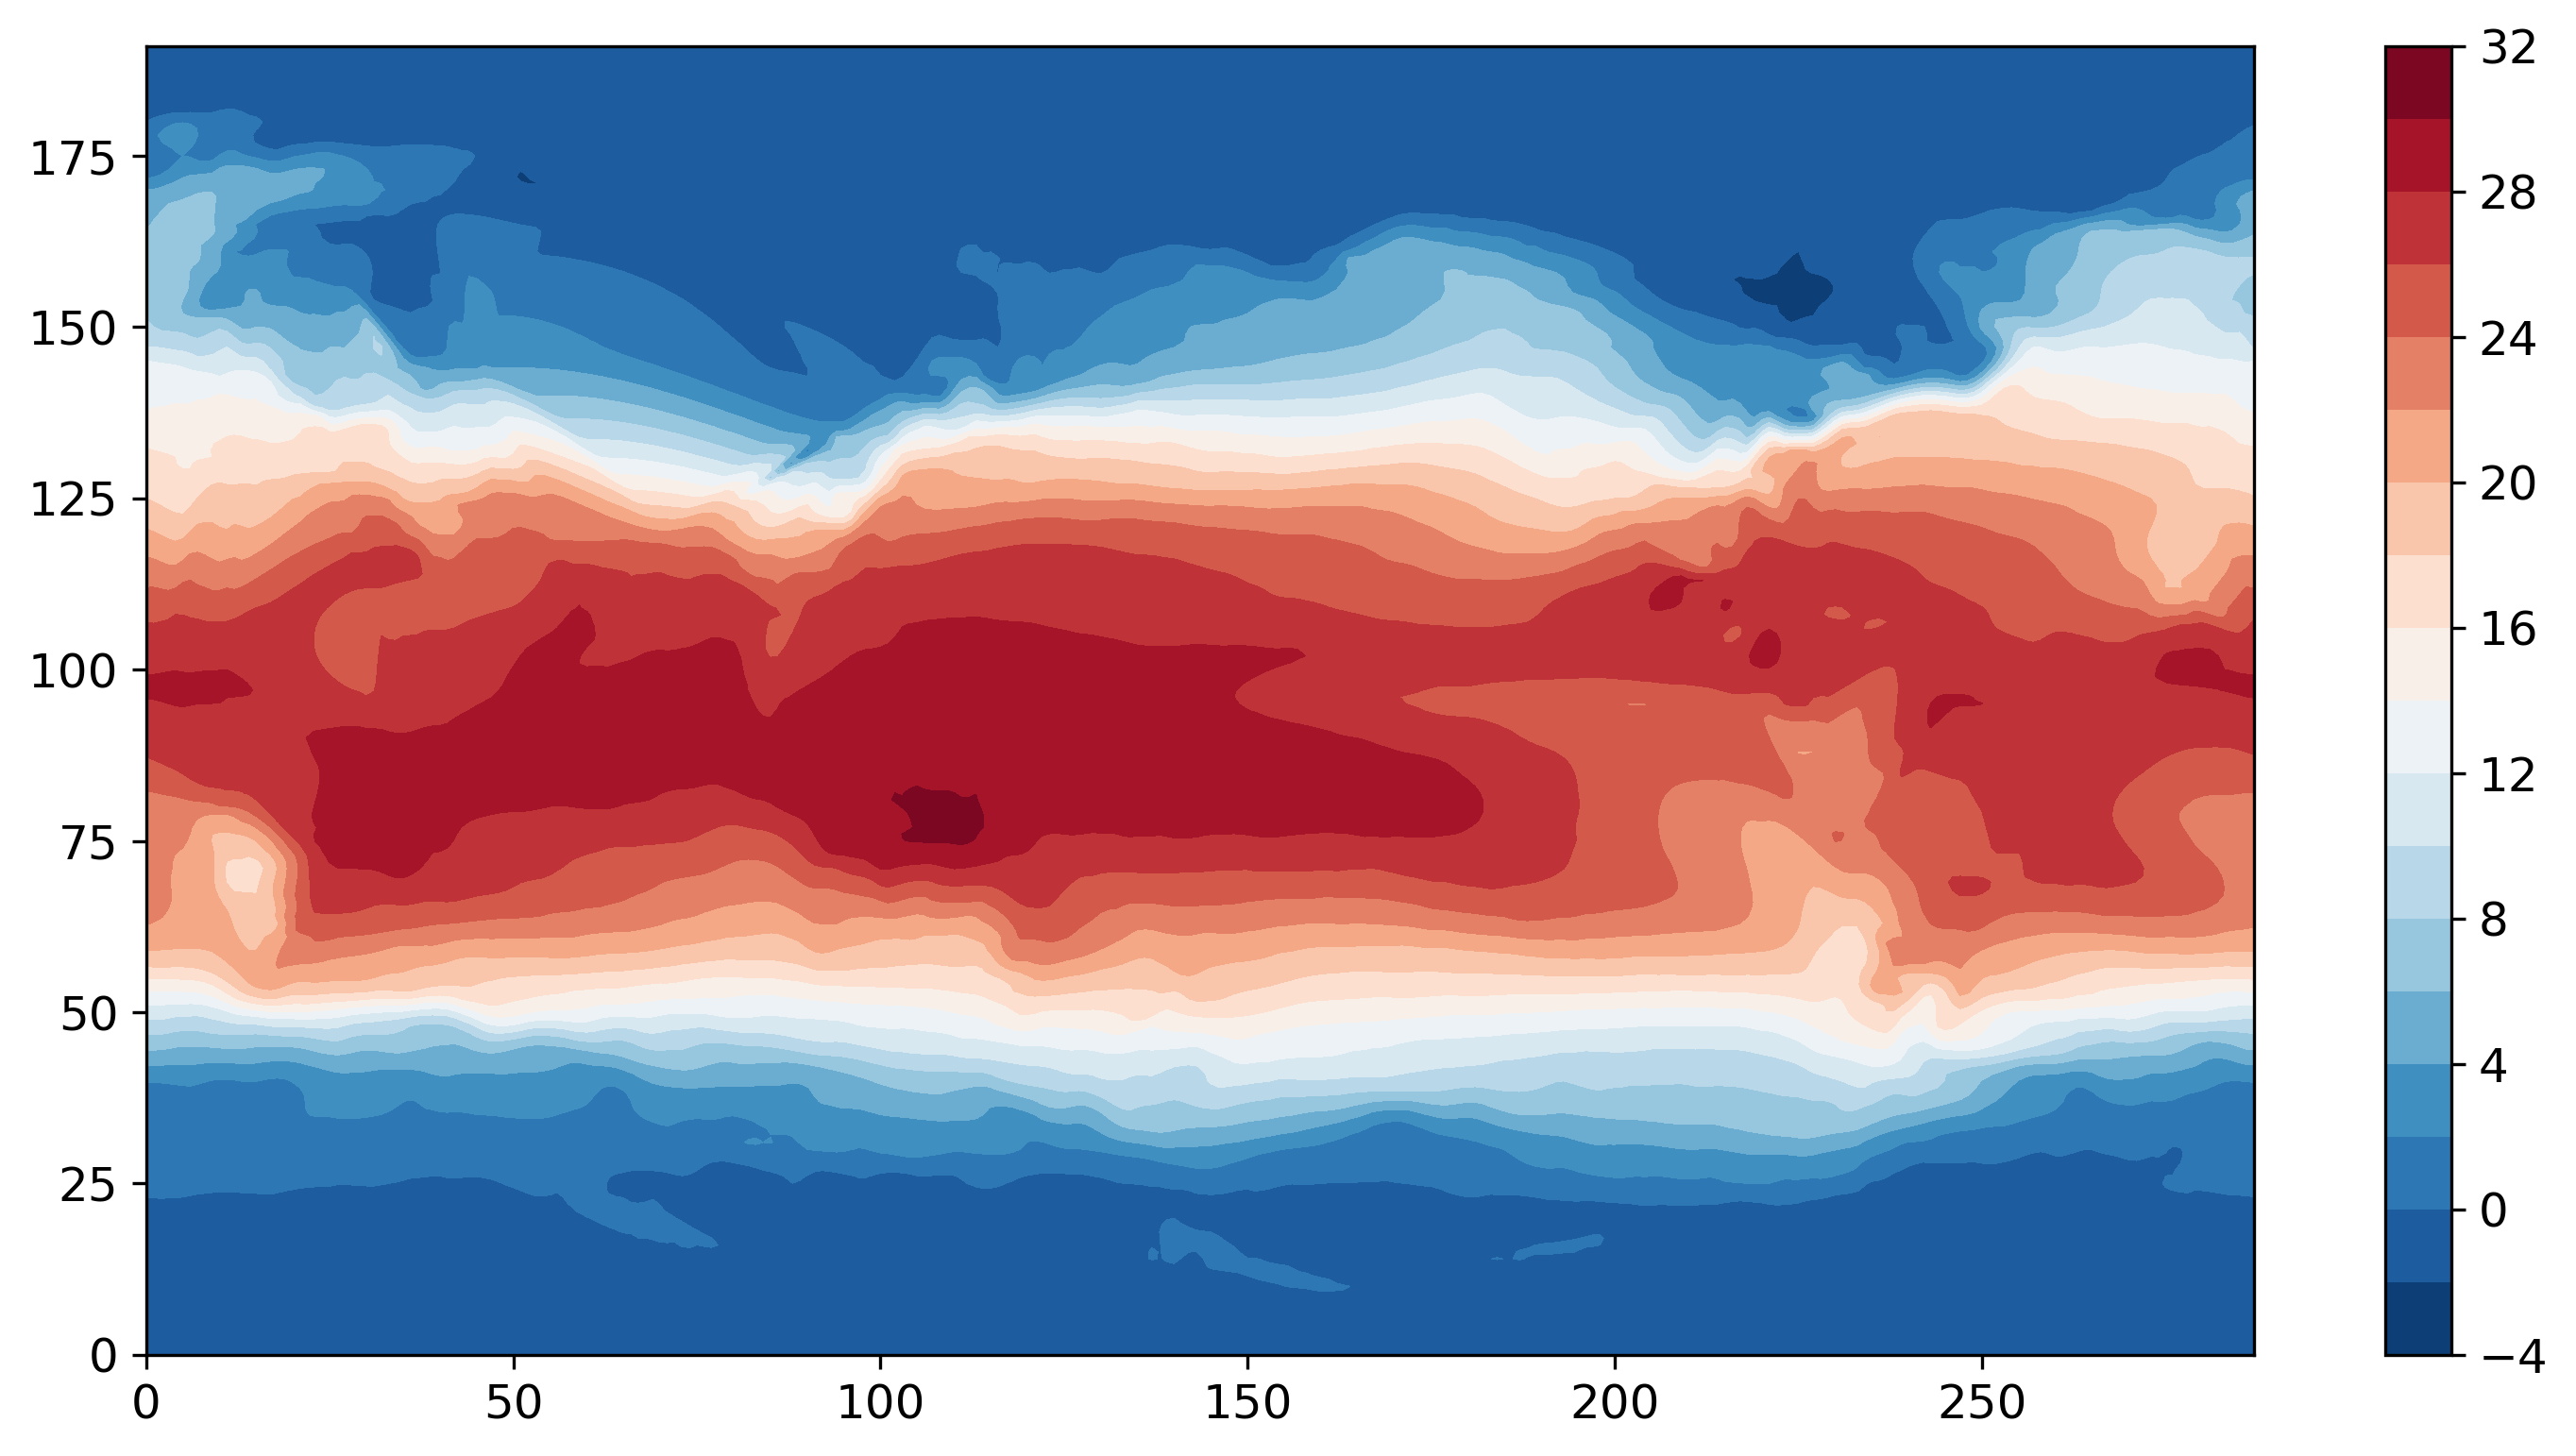

In [2220]:
plt.figure(figsize=(12,6), dpi=300.)
plt.contourf(SST_cpl[0], levels=21, cmap="RdBu_r")
# plt.contourf(SST_cpl[0], levels=21)
plt.colorbar()

# Calculate RMM index with TaiESM data Jan to June

In [878]:
# Read file
# with Dataset("f09.F2000_0101_0601_daily.nc", "r") as f:
with Dataset("/data92/PeterChang/ESM_2025/f09.F2000_MJO_1.5anomaly.cam.h0.1101_0201.nc", "r") as f:
    
    print(f.variables.keys())
    u850 = f["U850"][:]
    # v850 = f["V850"][:]
    q = f["Q"][:]
    PRECL = f["PRECL"][:]

dict_keys(['time', 'time_bnds', 'slat', 'lat', 'lon', 'lev', 'lev_bnds', 'ilev', 'ilev_bnds', 'date', 'datesec', 'w_stag', 'nlon', 'wnummax', 'gw', 'ndcur', 'nscur', 'co2vmr', 'ch4vmr', 'n2ovmr', 'f11vmr', 'f12vmr', 'sol_tsi', 'nsteph', 'AEROD_v', 'ANRAIN', 'ANSNOW', 'AODDUST1', 'AODDUST3', 'AODVIS', 'AQRAIN', 'AQSNOW', 'AREI', 'AREL', 'AWNC', 'AWNI', 'BURDEN1', 'BURDEN2', 'BURDEN3', 'BURDENBC', 'BURDENDUST', 'BURDENPOM', 'BURDENSEASALT', 'BURDENSO4', 'BURDENSOA', 'CCN3', 'CDNUMC', 'CGH', 'CGS', 'CLDHGH', 'CLDICE', 'CLDLIQ', 'CLDLOW', 'CLDMED', 'CLDTOT', 'CLOUD', 'DCQ', 'DMS_SRF', 'DTCOND', 'DTV', 'EMISCLD', 'FICE', 'FLDS', 'FLNS', 'FLNSC', 'FLNT', 'FLNTC', 'FLUT', 'FLUTC', 'FREQI', 'FREQL', 'FREQR', 'FREQS', 'FSDS', 'FSDSC', 'FSNS', 'FSNSC', 'FSNT', 'FSNTC', 'FSNTOA', 'FSNTOAC', 'FSUTOA', 'H2O2_SRF', 'H2SO4_SRF', 'ICEFRAC', 'ICIMR', 'ICWMR', 'IWC', 'KBFS', 'KHFS', 'KQFS', 'KSCT', 'KSCU', 'KVF', 'KVH', 'KVM', 'LANDFRAC', 'LHFLX', 'LWCF', 'NUMICE', 'NUMLIQ', 'OCNFRAC', 'OMEGA', 'OMEGAT'

In [879]:
# RMM plot
def plot_mjo_phase_space(figsize):
    
    import numpy as np
    from matplotlib import pyplot as plt
    import matplotlib.lines as lines
    
    fig, ax = plt.subplots(1,1,figsize=figsize) 
    
    ax.set_xlim(-4,4)
    ax.set_ylim(-4,4)
    ax.set_xticks(range(-4,5))
    ax.set_yticks(range(-4,5))

    # plot mjo phase diagram lines
    line1 = lines.Line2D([np.cos(np.pi/4), 4], [np.sin(np.pi/4), 4], color='black', linestyle='--', lw=1)
    ax.add_line(line1)
        
    line2 = lines.Line2D([np.cos(3*np.pi/4), -4], [np.sin(np.pi/4), 4], color='black', linestyle='--', lw=1)
    ax.add_line(line2)
        
    line3 = lines.Line2D([np.cos(np.pi/4), 4], [np.sin(7*np.pi/4), -4], color='black', linestyle='--', lw=1)
    ax.add_line(line3)
        
    line4 = lines.Line2D([np.cos(3*np.pi/4), -4], [np.sin(7*np.pi/4), -4], color='black', linestyle='--', lw=1)
    ax.add_line(line4)
        
    line5 = lines.Line2D([-4, -1], [0, 0], color='black', linestyle='--', lw=1)
    ax.add_line(line5)
        
    line6 = lines.Line2D([1, 4], [0, 0], color='black', linestyle='--', lw=1)
    ax.add_line(line6)
        
    line7 = lines.Line2D([0, 0], [1, 4], color='black', linestyle='--', lw=1)
    ax.add_line(line7)
        
    line8 = lines.Line2D([0, 0], [-1, -4], color='black', linestyle='--', lw=1)
    ax.add_line(line8)
        
    amp1_circ = plt.Circle((0, 0), 1, color='black', fill=False)
    ax.add_patch(amp1_circ)
        
    # add phase diagram texts
    ax.text( 1,3,'Phase 6', size='x-large', weight='semibold')
    ax.text(-2,3,'Phase 7', size='x-large', weight='semibold')
    ax.text(2.8,1  ,'Phase 5', size='x-large', weight='semibold', ha='center')
    ax.text(-2.8,1  ,'Phase 8', size='x-large', weight='semibold', ha='center')
        
    ax.text( 1,-3,'Phase 3', size='x-large', weight='semibold')
    ax.text(-2,-3,'Phase 2', size='x-large', weight='semibold')
    ax.text(2.8,-1  ,'Phase 4', size='x-large', weight='semibold', ha='center')
    ax.text(-2.8,-1  ,'Phase 1', size='x-large', weight='semibold', ha='center')
        
    ax.text( 0,3.7,'Pacific Ocean', ha='center', bbox=dict(facecolor='white', edgecolor='white'))
    ax.text( 0,-3.8,'Indian Ocean', ha='center', bbox=dict(facecolor='white', edgecolor='white'))
    ax.text(-3.8,0,'West. Hem., Africa', va='center', rotation='vertical', bbox=dict(facecolor='white', edgecolor='white'))
    ax.text(3.7,0,'Maritime Continent', va='center', rotation='vertical', bbox=dict(facecolor='white', edgecolor='white'))
        
    ax.set_xlabel('RMM1')
    ax.set_ylabel('RMM2')

    return fig, ax

Selected latitude indices: [ 80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97
  98  99 100 101 102 103 104 105 106 107 108 109 110 111]
Shape after latitude selection (u850): (92, 32, 288)
Integrated Q shape: (92, 32, 288)
Shape after latitude-weighted averaging (u850): (92, 288)
Filtered shape (u850): (92, 288)
Combined shape after preprocessing: (92, 864)
n_component: 92


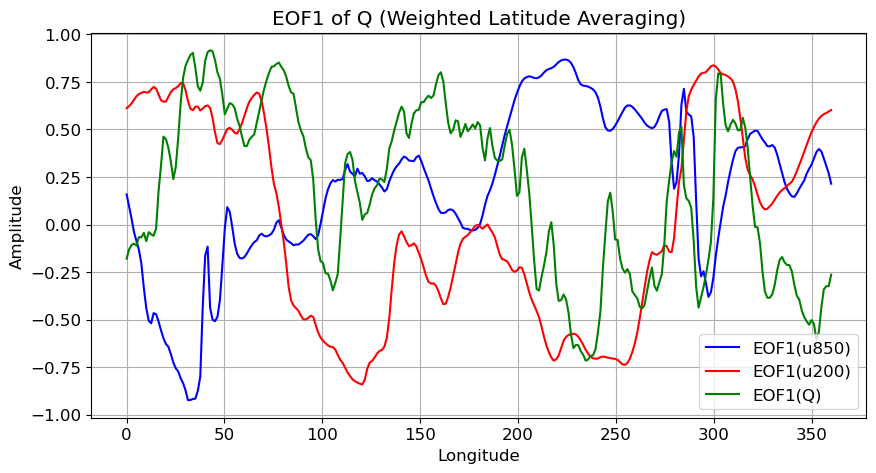

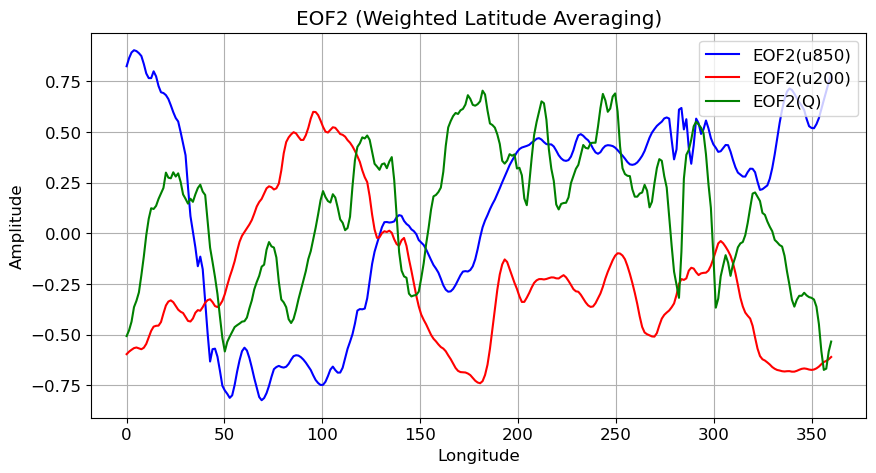

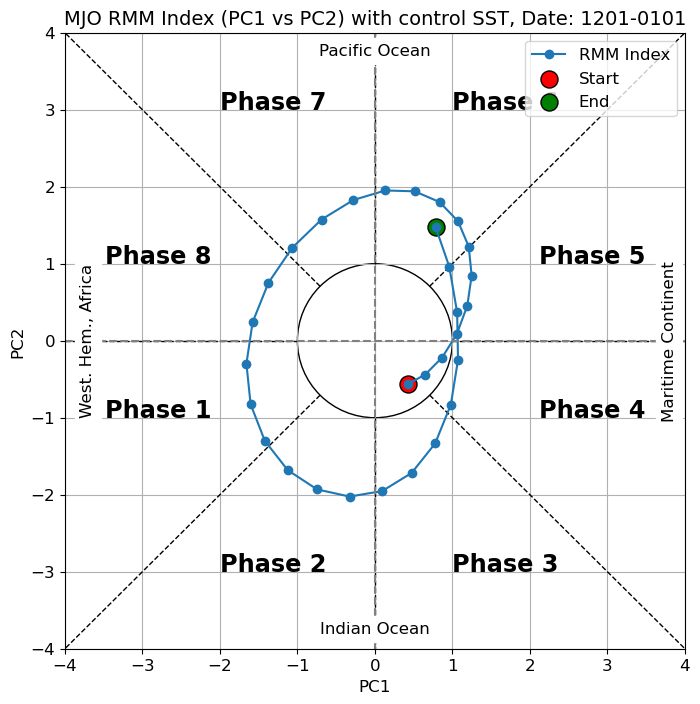

In [2213]:
from EOF import EOF
# Step 1: Load Data
with Dataset("f09.F2000_MJO_control_SST.cam.h0.0101_0401.nc", "r") as f:
    # print(f.variables.keys())
    u850 = f["U850"][:]
    v850 = f["V850"][:]
    precl = f["PRECL"][:]
    u200 = f["U200"][:]
    Q = f["FLNT"][:] 
    lat = f["lat"][:]
    time = f["time"][:]

# Step 2: Select latitude range (-15 to 15)
lat_mask = (lat >= -15) & (lat <= 15)
print("Selected latitude indices:", np.where(lat_mask)[0])

# Subset the data for the selected latitudes
u850 = u850[:, lat_mask, :]
v850 = v850[:, lat_mask, :]
precl = precl[:, lat_mask, :]
u200 = u200[:, lat_mask, :]
Q = Q[:, lat_mask, :]
print("Shape after latitude selection (u850):", u850.shape)


# Step 3: Column integrated Q (mean over levels)
# q_int = np.mean(Q, axis=1)  # Direct mean over vertical levels
q_int = Q
print("Integrated Q shape:", q_int.shape)

# Step 4: Latitude averaging with weighting
def latitude_weighted_average(data, lat):
    """
    Perform latitude-weighted averaging to obtain zonal mean.
    """
    # Calculate the weights
    weights = np.sqrt(np.cos(np.deg2rad(lat)))
    weights /= weights.sum()  # Normalize weights

    # Apply the weights to the data (broadcasting the weights along latitude)
    weighted_data = data * weights[:, np.newaxis]
    # Sum over latitude with weights applied
    return np.sum(weighted_data, axis=1)


# Apply latitude-weighted averaging to each variable
u850 = latitude_weighted_average(u850, lat[lat_mask])
v850 = latitude_weighted_average(v850, lat[lat_mask])
precl = latitude_weighted_average(precl, lat[lat_mask])
u200 = latitude_weighted_average(u200, lat[lat_mask])
q_int = latitude_weighted_average(q_int, lat[lat_mask])
print("Shape after latitude-weighted averaging (u850):", u850.shape)

# Step 5: Remove seasonal cycle with bandpass
from scipy.signal import filtfilt, butter

def band_pass_filter(data, lowcut=1/60, highcut=1/14, fs=1):
    """
    Band-pass filter to isolate MJO signals (14~60 days).
    """
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(2, [low, high], btype='band')
    return filtfilt(b, a, data, axis=0)

# Apply band-pass filter to isolate MJO signal
u850 = band_pass_filter(u850, lowcut=1/60, highcut=1/14)
u200 = band_pass_filter(u200, lowcut=1/60, highcut=1/14)
q_int = band_pass_filter(q_int, lowcut=1/60, highcut=1/14)
v850 = band_pass_filter(v850, lowcut=1/60, highcut=1/14)
precl = band_pass_filter(precl, lowcut=1/60, highcut=1/14)

print("Filtered shape (u850):", u850.shape)

# Step 6: Preprocess Data (remove overall mean and normalize)
def preprocess(data):
    data_anom = data - np.mean(data, axis=0) # anamoly to time
    data_std = np.std(data_anom, axis=0)
    # data_std[data_std == 0] = 1
    data_norm = data_anom / data_std
    return data_norm

# Preprocess each variable
u850_norm = preprocess(u850)
v850_norm = preprocess(v850)
u200_norm = preprocess(u200)
q_int_norm = preprocess(q_int)


# Step 7: Flatten and combine variables
time_dim, lon_dim = u850.shape
u850_flat = u850_norm.reshape(time_dim, lon_dim)
v850_flat = v850_norm.reshape(time_dim, lon_dim)

u200_flat = u200_norm.reshape(time_dim, lon_dim)
q_int_flat = q_int_norm.reshape(time_dim, lon_dim)

# combined = np.hstack((u850_flat, u200_flat, q_int_flat))
### FIXED! should use concatenate not hstack
# Concatenate in the correct order (variables are grouped, not mixed)
combined = np.concatenate((u850_flat, u200_flat, q_int_flat), axis=1) # (time, lon)
print("Combined shape after preprocessing:", combined.shape)

# Step 8: Calculate EOF and PC with latitude weighting
def Cal_EOF_PC(input_data):
    """
    Calculate EOF and PC from input data.
    """
    # Initialize an EOF instance
    n_component = min(input_data.shape[0], input_data.size // input_data.shape[0])
    print("n_component:", n_component)
    eof_instance = EOF((input_data,), n_components=n_component, field="1D")
    eof_instance.get()

    # Extract EOFs and PCs
    EOF1, EOF2, EOF3 = eof_instance.EOF[:3]
    PC1, PC2, PC3 = eof_instance.PC[:3]

    # Normalize PCs
    PC1_norm = (PC1 - PC1.mean()) / PC1.std()
    PC2_norm = (PC2 - PC2.mean()) / PC2.std()
    PC3_norm = (PC3 - PC3.mean()) / PC3.std()
    

    # EOFs with units 
    EOF1_norm = EOF1 * PC1.std() # (EOF1 - EOF1.mean()) / EOF1.std()
    EOF2_norm = EOF2 * PC2.std() # (EOF2 - EOF2.mean()) / EOF2.std()
    EOF3_norm = EOF3 * PC3.std() # (EOF2 - EOF2.mean()) / EOF2.std()
    
    return PC1_norm, PC2_norm, PC3_norm, EOF1_norm, EOF2_norm, EOF3_norm, eof_instance.explained[:10]


PC1, PC2, PC3, EOF1, EOF2, EOF3, explain = Cal_EOF_PC(combined)

# Step 9: Plot EOF1s
plt.figure(figsize=(10, 5))
plt.plot(np.linspace(0,360,288),EOF1[:288], label='EOF1(u850)', color='blue')
plt.plot(np.linspace(0,360,288),EOF1[288:288*2], label='EOF1(u200)', color='Red')
plt.plot(np.linspace(0,360,288),EOF1[288*2:288*3], label='EOF1(Q)', color='Green')


plt.title('EOF1 of Q (Weighted Latitude Averaging)')
plt.xlabel('Longitude')
plt.ylabel('Amplitude')
plt.grid(True)
plt.legend()
plt.show()

# Step 9: Plot EOF1 of Q
plt.figure(figsize=(10, 5))
plt.plot(np.linspace(0,360,288),EOF2[:288], label='EOF2(u850)', color='blue')
plt.plot(np.linspace(0,360,288),EOF2[288:288*2], label='EOF2(u200)', color='Red')
plt.plot(np.linspace(0,360,288),EOF2[288*2:288*3], label='EOF2(Q)', color='Green')


plt.title('EOF2 (Weighted Latitude Averaging)')
plt.xlabel('Longitude')
plt.ylabel('Amplitude')
plt.grid(True)
plt.legend()
plt.show()


# Step 10: Plot RMM Index (PC1 vs PC2)
# 用固定半徑與角度生成一圈
theta = np.linspace(0, 2 * np.pi, 30)
radius = 0.85  # 固定 amplitude，可自由調整

PC1_demo = radius * np.cos(theta)  # RMM1
PC2_demo = radius * np.sin(theta)  # RMM2


start = 30
end   = 60
fig, ax = plot_mjo_phase_space(figsize=(8,8))
ax.plot(PC1[start:end], PC2[start:end], marker='o', linestyle='-', label='RMM Index')
# ax.plot(PC1_demo[17:], PC2_demo[17:], marker='o', linestyle='-', color="Blue", label='RMM Index')
# ax.plot(PC1_demo[:13], PC2_demo[:13], marker='o', linestyle='-', color="Blue")
# ax.scatter(PC1_demo[17], PC2_demo[17], color='red', edgecolors='black', s=150, label='Start')
# ax.scatter(PC1_demo[int(13-1)], PC2_demo[int(13-1)], color='green', edgecolors='black', s=150, label='End')



ax.scatter(PC1[start], PC2[start], color='red', edgecolors='black', s=150, label='Start')
ax.scatter(PC1[int(end-1)], PC2[int(end-1)], color='green', edgecolors='black', s=150, label='End')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('MJO RMM Index (PC1 vs PC2) with control SST, Date: 1201-0101', fontsize=14)
ax.axhline(0, color='gray', linestyle='--')
ax.axvline(0, color='gray', linestyle='--')
ax.grid(True)
ax.legend()
plt.show()

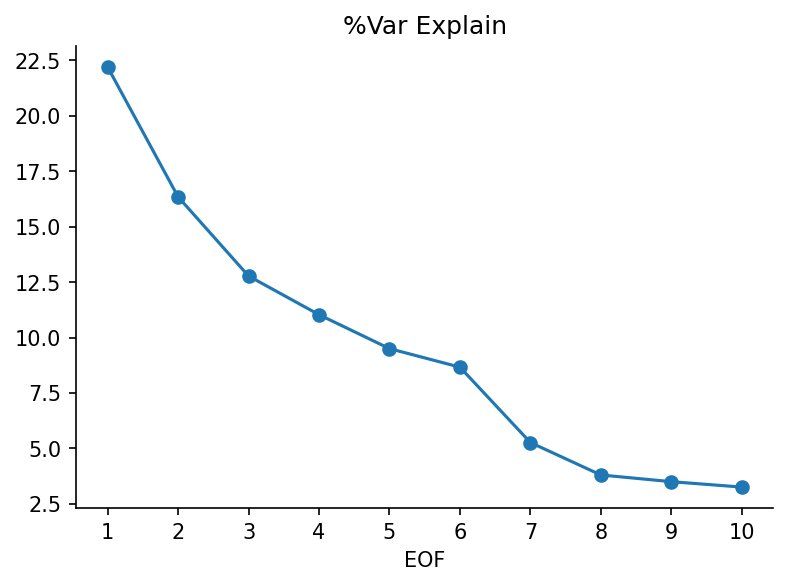

In [236]:
fig, ax = plt.subplots(1, figsize=(6,4), dpi=150)
ax.plot(np.arange(1,11,1), explain * 100, '-o')
ax.set_title("%Var Explain")
ax.set_xlabel("EOF")
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.set_xticks(np.arange(1, 11, 1))  
plt.show()


In [383]:
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
from scipy.signal import filtfilt, butter
from EOF import EOF

class MJO_EOF_Analyzer:
    def __init__(self, filename):
        self.filename = filename
        self._load_data()
        self._select_latitude_range()
        self._latitude_weighted_average()
        self._band_pass_filter()
        self._preprocess()
        self._combine_and_compute_eof()

    def _load_data(self):
        with Dataset(self.filename, "r") as f:
            self.u850 = f["U850"][:]
            self.v850 = f["V850"][:]
            self.precl = f["PRECL"][:]
            self.u200 = f["U200"][:]
            self.Q = f["FLNT"][:] 
            self.lat = f["lat"][:]
            self.time = f["time"][:]
    
    def _select_latitude_range(self):
        lat_mask = (self.lat >= -15) & (self.lat <= 15)
        self.lat_mask = lat_mask
        self.lat_selected = self.lat[lat_mask]
        self.u850 = self.u850[:, lat_mask, :]
        self.v850 = self.v850[:, lat_mask, :]
        self.precl = self.precl[:, lat_mask, :]
        self.u200 = self.u200[:, lat_mask, :]
        self.Q = self.Q[:, lat_mask, :]

    def _latitude_weighted_average(self):
        def lat_weighted(data, lat):
            weights = np.sqrt(np.cos(np.deg2rad(lat)))
            weights /= weights.sum()
            return np.sum(data * weights[:, np.newaxis], axis=1)

        self.u850 = lat_weighted(self.u850, self.lat_selected)
        self.v850 = lat_weighted(self.v850, self.lat_selected)
        self.u200 = lat_weighted(self.u200, self.lat_selected)
        self.precl = lat_weighted(self.precl, self.lat_selected)
        self.q_int = lat_weighted(self.Q, self.lat_selected)

    def _band_pass_filter(self, lowcut=1/33, highcut=1/15, fs=1):
        def bandpass(data):
            nyquist = 0.5 * fs
            b, a = butter(2, [lowcut/nyquist, highcut/nyquist], btype='band')
            return filtfilt(b, a, data, axis=0)

        self.u850 = bandpass(self.u850)
        self.v850 = bandpass(self.v850)
        self.u200 = bandpass(self.u200)
        self.precl = bandpass(self.precl)
        self.q_int = bandpass(self.q_int)

    def _preprocess(self):
        def standardize(data):
            anomaly = data - np.mean(data, axis=0)
            return anomaly / np.std(anomaly, axis=0)

        self.u850 = standardize(self.u850)
        self.v850 = standardize(self.v850)
        self.u200 = standardize(self.u200)
        self.q_int = standardize(self.q_int)

    def _combine_and_compute_eof(self):
        time_dim, lon_dim = self.u850.shape
        flat_u850 = self.u850.reshape(time_dim, lon_dim)
        flat_u200 = self.u200.reshape(time_dim, lon_dim)
        flat_qint = self.q_int.reshape(time_dim, lon_dim)
        combined = np.concatenate((flat_u850, flat_u200, flat_qint), axis=1)

        eof_instance = EOF((combined,), n_components=10, field="1D")
        eof_instance.get()
        PC1 = eof_instance.PC[0]
        PC2 = eof_instance.PC[1]

        # Normalize PCs
        self.PC1 = (PC1 - PC1.mean()) / PC1.std()
        self.PC2 = (PC2 - PC2.mean()) / PC2.std()
        self.explained = eof_instance.explained[:3]

    def get_pc1_pc2(self):
        return self.PC1, self.PC2


In [384]:
def plot_mjo_phase_space_ax(ax):
    import numpy as np
    import matplotlib.lines as lines

    ax.set_xlim(-4, 4)
    ax.set_ylim(-4, 4)
    ax.set_xticks(range(-4, 5))
    ax.set_yticks(range(-4, 5))

    # plot MJO phase diagram lines
    ax.add_line(lines.Line2D([np.cos(np.pi/4), 4], [np.sin(np.pi/4), 4], color='black', linestyle='--', lw=1))
    ax.add_line(lines.Line2D([np.cos(3*np.pi/4), -4], [np.sin(np.pi/4), 4], color='black', linestyle='--', lw=1))
    ax.add_line(lines.Line2D([np.cos(np.pi/4), 4], [np.sin(7*np.pi/4), -4], color='black', linestyle='--', lw=1))
    ax.add_line(lines.Line2D([np.cos(3*np.pi/4), -4], [np.sin(7*np.pi/4), -4], color='black', linestyle='--', lw=1))
    ax.add_line(lines.Line2D([-4, -1], [0, 0], color='black', linestyle='--', lw=1))
    ax.add_line(lines.Line2D([1, 4], [0, 0], color='black', linestyle='--', lw=1))
    ax.add_line(lines.Line2D([0, 0], [1, 4], color='black', linestyle='--', lw=1))
    ax.add_line(lines.Line2D([0, 0], [-1, -4], color='black', linestyle='--', lw=1))

    amp1_circ = plt.Circle((0, 0), 1, color='black', fill=False)
    ax.add_patch(amp1_circ)

    # add phase diagram texts
    ax.text(1, 3, 'Phase 6', size='medium', weight='semibold')
    ax.text(-2, 3, 'Phase 7', size='medium', weight='semibold')
    ax.text(2.8, 1, 'Phase 5', size='medium', weight='semibold', ha='center')
    ax.text(-2.8, 1, 'Phase 8', size='medium', weight='semibold', ha='center')
    ax.text(1, -3, 'Phase 3', size='medium', weight='semibold')
    ax.text(-2, -3, 'Phase 2', size='medium', weight='semibold')
    ax.text(2.8, -1, 'Phase 4', size='medium', weight='semibold', ha='center')
    ax.text(-2.8, -1, 'Phase 1', size='medium', weight='semibold', ha='center')

    ax.text(0, 3.7, 'Pacific Ocean', ha='center', bbox=dict(facecolor='white', edgecolor='white'))
    ax.text(0, -3.8, 'Indian Ocean', ha='center', bbox=dict(facecolor='white', edgecolor='white'))
    ax.text(-3.8, 0, 'West. Hem., Africa', va='center', rotation='vertical', bbox=dict(facecolor='white', edgecolor='white'))
    ax.text(3.7, 0, 'Maritime Continent', va='center', rotation='vertical', bbox=dict(facecolor='white', edgecolor='white'))

    ax.set_xlabel('RMM1')
    ax.set_ylabel('RMM2')
    ax.grid(True)


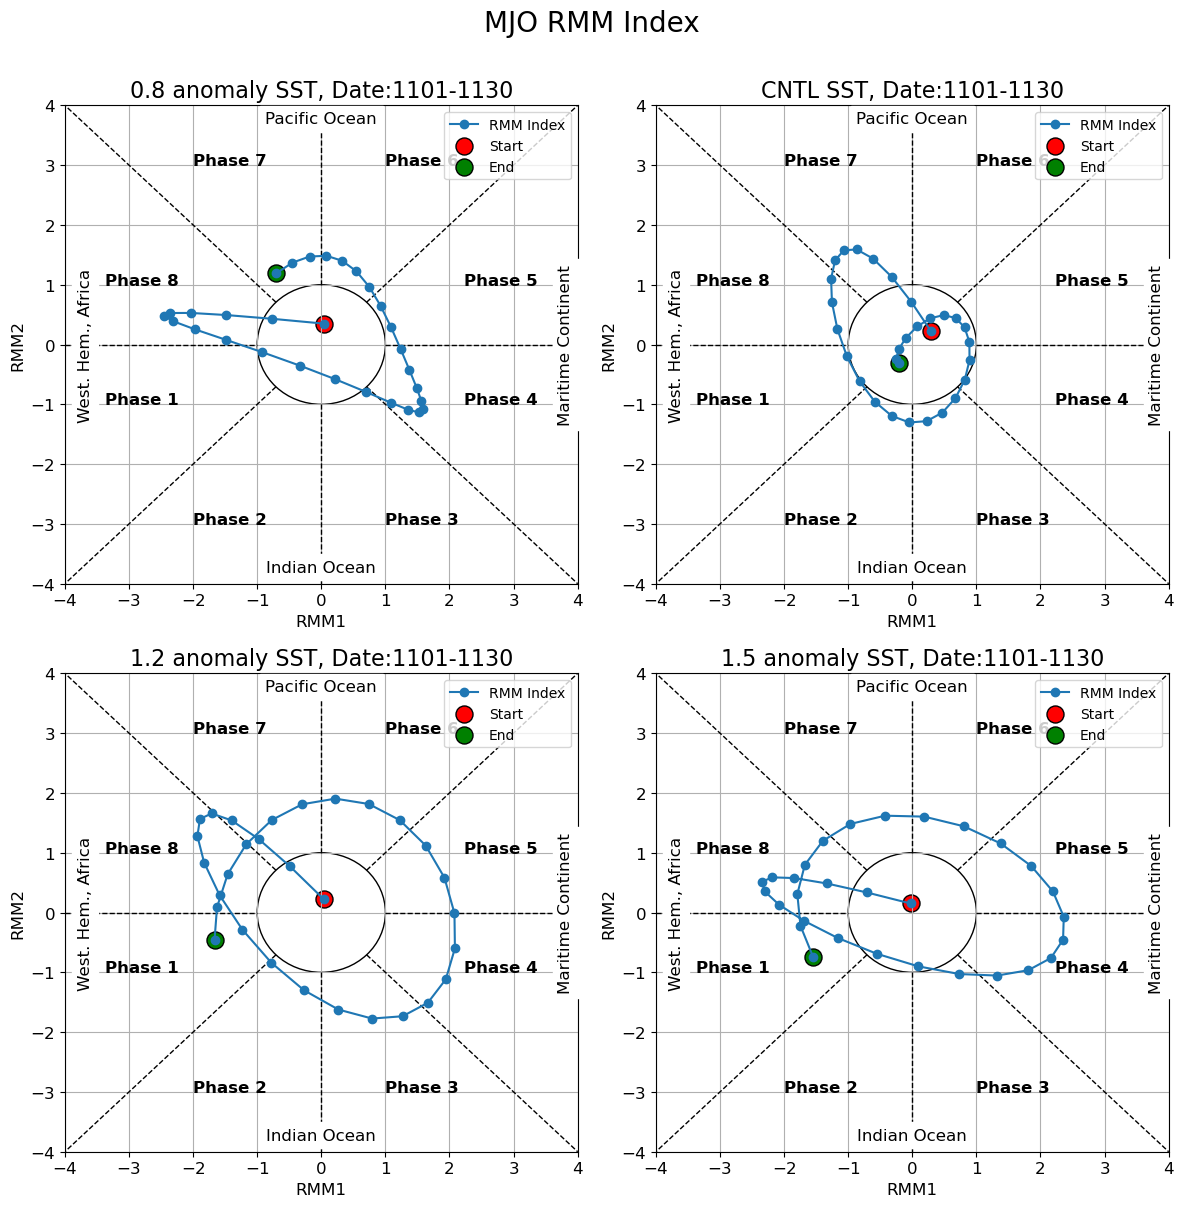

In [2214]:
files = [
    "f09.F2000_MJO_0.8anomaly.cam.h0.1101_0201.nc",
    "f09.F2000_MJO_control.cam.h0.1101_0201.nc",
    "f09.F2000_MJO_1.2anomaly.cam.h0.1101_0201.nc",
    "f09.F2000_MJO_1.5anomaly.cam.h0.1101_0201.nc"
]

titles = ["0.8 anomaly", "CNTL", "1.2 anomaly", "1.5 anomaly"]
pcs = []

# 跑四個實驗
for f in files:
    analyzer = MJO_EOF_Analyzer(f)
    pcs.append(analyzer.get_pc1_pc2())
    
start = 0
end = 30

fig, axs = plt.subplots(2, 2, figsize=(12, 12))  # 2 rows, 2 columns
axs = axs.flat  # flatten to 1D array for easier looping

for i, ax in enumerate(axs):
    PC1, PC2 = pcs[i]
    if i ==0:
        PC1, PC2 = -PC1, -PC2
    elif i == 1:
        PC1, PC2 = PC1, -PC2

    elif i == 2:
        PC1, PC2 = PC1, -PC2

    elif i == 3:
        PC1, PC2 = PC1, PC2
        
        
    plot_mjo_phase_space_ax(ax)  # 畫 RMM 背景圖
    
    ax.plot(PC1[start:end], PC2[start:end], marker='o', linestyle='-', label='RMM Index')
    ax.scatter(PC1[start], PC2[start], color='red', edgecolors='black', s=150, label='Start')
    ax.scatter(PC1[end-1], PC2[end-1], color='green', edgecolors='black', s=150, label='End')
    
    ax.set_title(f"{titles[i]} SST, Date:1101-1130", fontsize=16)
    ax.set_xlim(-4, 4)
    ax.set_ylim(-4, 4)
    ax.legend(fontsize=10)

plt.suptitle("MJO RMM Index", fontsize=20, y=1.005)
plt.tight_layout()
# plt.savefig("/data92/PeterChang/ESM_2025/Figures/result.png", dpi=300., bbox_inches='tight')
plt.show()


# MJO regression map

Selected latitude indices: [ 80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97
  98  99 100 101 102 103 104 105 106 107 108 109 110 111]
Shape after latitude selection (u850): (366, 32, 288)
Integrated Q shape: (366, 32, 288)
Shape after latitude-weighted averaging (u850): (366, 288)
Filtered shape (u850): (366, 288)
Combined shape after preprocessing: (366, 864)
n_component: 366


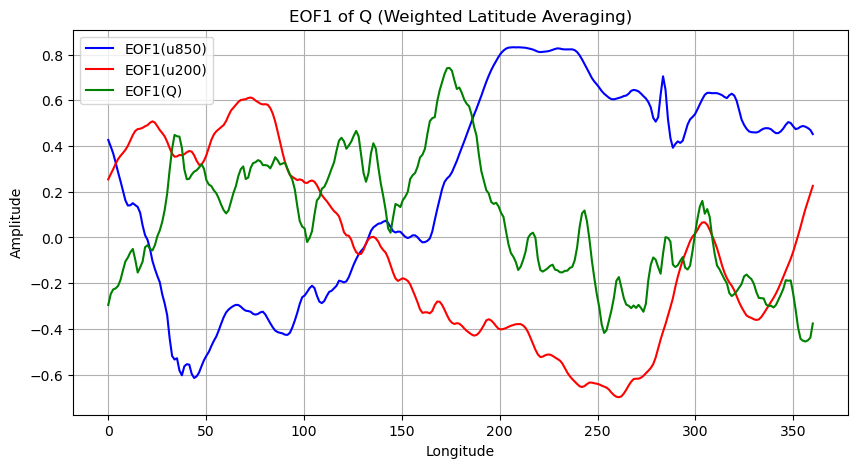

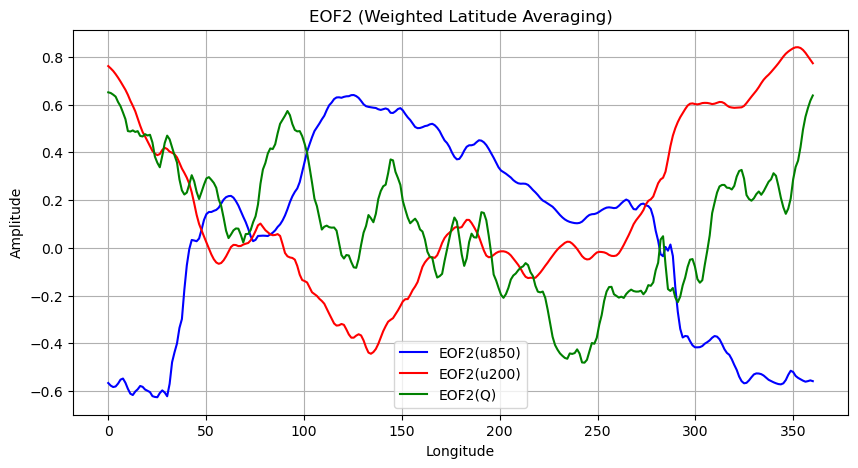

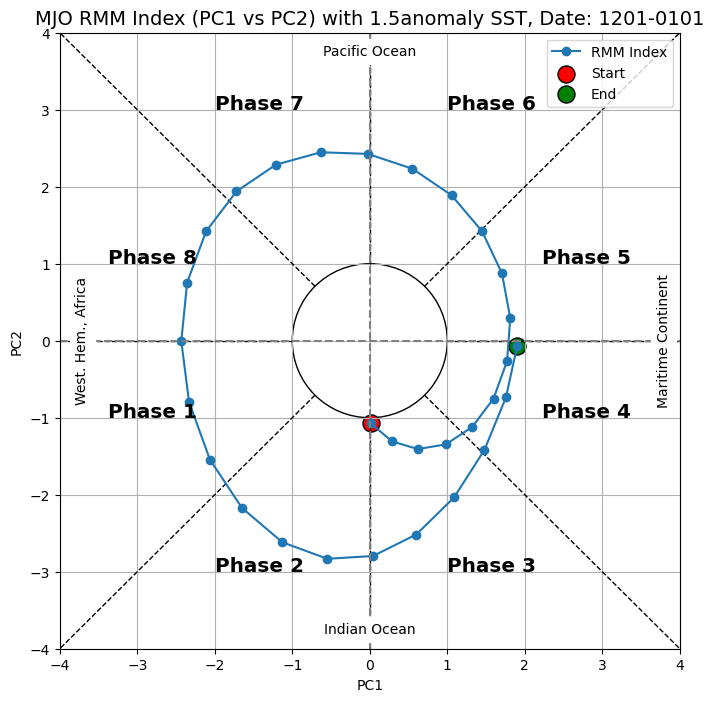

In [1791]:
from EOF import EOF
# Step 1: Load Data
# with Dataset("f09.F2000_MJO_1.5anomaly.cam.h0.1101_0201.nc", "r") as f:
with Dataset("f09.F2000_MJO_1year.cam.h0.1year.nc", "r") as f:
    
    # print(f.variables.keys())
    u850 = f["U850"][:]
    v850 = f["V850"][:]
    precl = f["PRECL"][:]
    u200 = f["U200"][:]
    Q = f["FLNT"][:] 
    lat = f["lat"][:]
    time = f["time"][:]

# Step 2: Select latitude range (-15 to 15)
lat_mask = (lat >= -15) & (lat <= 15)
print("Selected latitude indices:", np.where(lat_mask)[0])

# Subset the data for the selected latitudes
u850 = u850[:, lat_mask, :]
v850 = v850[:, lat_mask, :]
precl = precl[:, lat_mask, :]
u200 = u200[:, lat_mask, :]
Q = Q[:, lat_mask, :]
print("Shape after latitude selection (u850):", u850.shape)


# Step 3: Column integrated Q (mean over levels)
# q_int = np.mean(Q, axis=1)  # Direct mean over vertical levels
q_int = Q
print("Integrated Q shape:", q_int.shape)

# Step 4: Latitude averaging with weighting
def latitude_weighted_average(data, lat):
    """
    Perform latitude-weighted averaging to obtain zonal mean.
    """
    # Calculate the weights
    weights = np.sqrt(np.cos(np.deg2rad(lat)))
    weights /= weights.sum()  # Normalize weights

    # Apply the weights to the data (broadcasting the weights along latitude)
    weighted_data = data * weights[:, np.newaxis]
    # Sum over latitude with weights applied
    return np.sum(weighted_data, axis=1)


# Apply latitude-weighted averaging to each variable
u850 = latitude_weighted_average(u850, lat[lat_mask])
v850 = latitude_weighted_average(v850, lat[lat_mask])
precl = latitude_weighted_average(precl, lat[lat_mask])
u200 = latitude_weighted_average(u200, lat[lat_mask])
q_int = latitude_weighted_average(q_int, lat[lat_mask])
print("Shape after latitude-weighted averaging (u850):", u850.shape)

# Step 5: Remove seasonal cycle with bandpass
from scipy.signal import filtfilt, butter

def band_pass_filter(data, lowcut=1/60, highcut=1/14, fs=1):
    """
    Band-pass filter to isolate MJO signals (14~60 days).
    """
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(2, [low, high], btype='band')
    return filtfilt(b, a, data, axis=0)

# Apply band-pass filter to isolate MJO signal
u850 = band_pass_filter(u850, lowcut=1/60, highcut=1/14)
u200 = band_pass_filter(u200, lowcut=1/60, highcut=1/14)
q_int = band_pass_filter(q_int, lowcut=1/60, highcut=1/14)
v850 = band_pass_filter(v850, lowcut=1/60, highcut=1/14)
precl = band_pass_filter(precl, lowcut=1/60, highcut=1/14)

print("Filtered shape (u850):", u850.shape)

# Step 6: Preprocess Data (remove overall mean and normalize)
def preprocess(data):
    data_anom = data - np.mean(data, axis=0) # anamoly to time
    data_std = np.std(data_anom, axis=0)
    # data_std[data_std == 0] = 1
    data_norm = data_anom / data_std
    return data_norm

# Preprocess each variable
u850_norm = preprocess(u850)
v850_norm = preprocess(v850)
u200_norm = preprocess(u200)
q_int_norm = preprocess(q_int)


# Step 7: Flatten and combine variables
time_dim, lon_dim = u850.shape
u850_flat = u850_norm.reshape(time_dim, lon_dim)
v850_flat = v850_norm.reshape(time_dim, lon_dim)

u200_flat = u200_norm.reshape(time_dim, lon_dim)
q_int_flat = q_int_norm.reshape(time_dim, lon_dim)

# combined = np.hstack((u850_flat, u200_flat, q_int_flat))
### FIXED! should use concatenate not hstack
# Concatenate in the correct order (variables are grouped, not mixed)
combined = np.concatenate((u850_flat, u200_flat, q_int_flat), axis=1) # (time, lon)
print("Combined shape after preprocessing:", combined.shape)

# Step 8: Calculate EOF and PC with latitude weighting
def Cal_EOF_PC(input_data):
    """
    Calculate EOF and PC from input data.
    """
    # Initialize an EOF instance
    n_component = min(input_data.shape[0], input_data.size // input_data.shape[0])
    print("n_component:", n_component)
    eof_instance = EOF((input_data,), n_components=n_component, field="1D")
    eof_instance.get()

    # Extract EOFs and PCs
    EOF1, EOF2, EOF3 = eof_instance.EOF[:3]
    PC1, PC2, PC3 = eof_instance.PC[:3]

    # Normalize PCs
    PC1_norm = (PC1 - PC1.mean()) / PC1.std()
    PC2_norm = (PC2 - PC2.mean()) / PC2.std()
    PC3_norm = (PC3 - PC3.mean()) / PC3.std()
    

    # EOFs with units 
    EOF1_norm = EOF1 * PC1.std() # (EOF1 - EOF1.mean()) / EOF1.std()
    EOF2_norm = EOF2 * PC2.std() # (EOF2 - EOF2.mean()) / EOF2.std()
    EOF3_norm = EOF3 * PC3.std() # (EOF2 - EOF2.mean()) / EOF2.std()
    
    return PC1_norm, PC2_norm, PC3_norm, EOF1_norm, EOF2_norm, EOF3_norm, eof_instance.explained[:10]


PC1, PC2, PC3, EOF1, EOF2, EOF3, explain = Cal_EOF_PC(combined)

# Step 9: Plot EOF1s
plt.figure(figsize=(10, 5))
plt.plot(np.linspace(0,360,288),EOF1[:288], label='EOF1(u850)', color='blue')
plt.plot(np.linspace(0,360,288),EOF1[288:288*2], label='EOF1(u200)', color='Red')
plt.plot(np.linspace(0,360,288),EOF1[288*2:288*3], label='EOF1(Q)', color='Green')


plt.title('EOF1 of Q (Weighted Latitude Averaging)')
plt.xlabel('Longitude')
plt.ylabel('Amplitude')
plt.grid(True)
plt.legend()
plt.show()

# Step 9: Plot EOF1 of Q
plt.figure(figsize=(10, 5))
plt.plot(np.linspace(0,360,288),EOF2[:288], label='EOF2(u850)', color='blue')
plt.plot(np.linspace(0,360,288),EOF2[288:288*2], label='EOF2(u200)', color='Red')
plt.plot(np.linspace(0,360,288),EOF2[288*2:288*3], label='EOF2(Q)', color='Green')


plt.title('EOF2 (Weighted Latitude Averaging)')
plt.xlabel('Longitude')
plt.ylabel('Amplitude')
plt.grid(True)
plt.legend()
plt.show()


# Step 10: Plot RMM Index (PC1 vs PC2)
# 用固定半徑與角度生成一圈
theta = np.linspace(0, 2 * np.pi, 30)
radius = 0.85  # 固定 amplitude，可自由調整

PC1_demo = radius * np.cos(theta)  # RMM1
PC2_demo = radius * np.sin(theta)  # RMM2


start = 30
end   = 60
fig, ax = plot_mjo_phase_space(figsize=(8,8))
ax.plot(PC1[start:end], -PC2[start:end], marker='o', linestyle='-', label='RMM Index')
# ax.plot(PC1_demo[17:], PC2_demo[17:], marker='o', linestyle='-', color="Blue", label='RMM Index')
# ax.plot(PC1_demo[:13], PC2_demo[:13], marker='o', linestyle='-', color="Blue")
# ax.scatter(PC1_demo[17], PC2_demo[17], color='red', edgecolors='black', s=150, label='Start')
# ax.scatter(PC1_demo[int(13-1)], PC2_demo[int(13-1)], color='green', edgecolors='black', s=150, label='End')



ax.scatter(PC1[start], -PC2[start], color='red', edgecolors='black', s=150, label='Start')
ax.scatter(PC1[int(end-1)], -PC2[int(end-1)], color='green', edgecolors='black', s=150, label='End')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('MJO RMM Index (PC1 vs PC2) with 1.5anomaly SST, Date: 1201-0101', fontsize=14)
ax.axhline(0, color='gray', linestyle='--')
ax.axvline(0, color='gray', linestyle='--')
ax.grid(True)
ax.legend()
plt.show()

In [1180]:
# with Dataset("f09.F2000_MJO_1year.cam.h0.1year.nc", "r") as f:
    
#     Q = f["FLNT"][:]      # shape (time, lat, lon)   
# Q_eq = Q[:, lat_band,:].mean(axis=1)
# from scipy.fft import fft, ifft, fftfreq
# # Apply FFT along specified dimensions while keeping xarray metadata

# q1_fft: np.ndarray = fft(Q_eq, axis=0); # fft on time
# q1_fft: np.ndarray = ifft(q1_fft, axis=1) * lon.shape[0]; # fft on lon

# # Apply bandpass filter on q1_fft
# fr: np.ndarray = fftfreq(Q_eq.shape[0], d=1);
# wn: np.ndarray = fftfreq(Q_eq.shape[1], d=1/lon.shape[0]).astype(int);

# wnm, frm = np.meshgrid(wn, fr);

# ## define kelvin waves curve
# # kel_curve = lambda wn, ed: wn * np.sqrt(9.81 * ed) * (86400 / (2*np.pi*6.371e6));

# q1_sel: np.ndarray = np.where(
#     ((wnm >= 1) & (wnm <=5) &
#     (frm >= 1/90) & (frm <= 1/30)# &
#     #(frm >= kel_curve(wnm, 8)) & (frm <= kel_curve(wnm, 90))
#      ) |
#     ((wnm <= -1) & (wnm >=-5) &
#     (frm <= -1/90) & (frm >= -1/30) #&
#     #(frm <= kel_curve(wnm, 8)) & (frm >= kel_curve(wnm, 90))
#     ), 1, 0
#         );

# kel_sel = q1_fft * q1_sel[:, :];

# # reconstruct q1
# q1_recon = fft(kel_sel, axis=1) / lon.shape[0];
# q1_recon = ifft(q1_recon, axis=0).real

(288,)

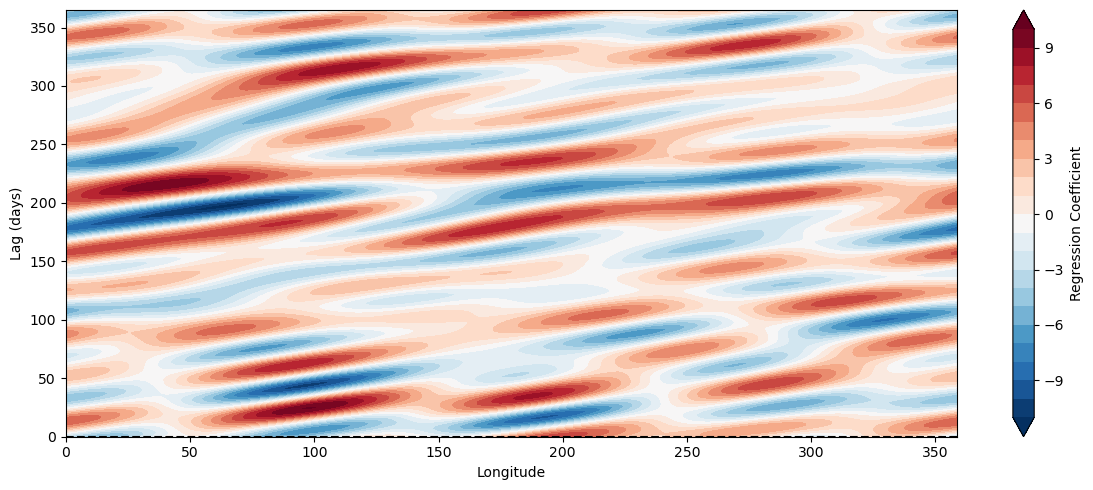

In [1186]:
# plt.figure(figsize=(12, 5))

# # 計算對稱範圍，最大絕對值
# vabs = np.nanmax(np.abs(reg_map))

# norm = TwoSlopeNorm(vmin=-vabs, vcenter=0, vmax=vabs)

# cf = plt.contourf(
#     lon, time, q1_recon,
#     levels=21,
#     cmap="RdBu_r",
#     # norm=norm,
#     extend="both"
# )

# plt.axhline(0, color='k', linestyle='--')
# plt.xlabel("Longitude")
# plt.ylabel("Lag (days)")
# # plt.title(title)
# plt.colorbar(cf, label="Regression Coefficient")
# plt.tight_layout()
# plt.show()

In [1190]:
# import numpy as np
# from scipy.fft import fft, ifft, fftfreq

# class MJOFilter:
#     def __init__(self, wavenumber_range=(1, 5), period_range=(30, 90)):
#         """
#         Parameters:
#         - wavenumber_range: tuple (min_k, max_k), zonal wavenumber range
#         - period_range: tuple (min_period, max_period), in days
#         """
#         self.kmin, self.kmax = wavenumber_range
#         self.pmin, self.pmax = period_range
#         self.q_recon = None
#         self.lon = None
#         self.time = None

#     def fit_transform(self, Q, lat, lon, lat_range=(-15, 15)):
#         """
#         Apply MJO band-pass filtering on Q(time, lat, lon)

#         Returns:
#         - q_recon: filtered Q_eq(time, lon) with only MJO signals
#         """
#         lat_mask = (lat >= lat_range[0]) & (lat <= lat_range[1])
#         Q_eq = Q[:, lat_mask, :].mean(axis=1)  # (time, lon)

#         ntime, nlon = Q_eq.shape
#         self.lon = lon
#         self.time = np.arange(ntime)

#         # FFT (time axis)
#         q_fft_time = fft(Q_eq, axis=0)  # (time_f, lon)
#         q_fft_wavenum = ifft(q_fft_time, axis=1) * nlon  # (time_f, wavenum)

#         # Build freq-wavenumber grid
#         freq = fftfreq(ntime, d=1)  # cycles/day
#         wn = fftfreq(nlon, d=1/nlon).astype(int)
#         wnm, frm = np.meshgrid(wn, freq)

#         # MJO mask: eastward wavenumber and ~30–90 day period
#         mjo_mask = (
#             (wnm >= self.kmin) & (wnm <= self.kmax) &
#             (frm >= 1 / self.pmax) & (frm <= 1 / self.pmin)
#         )

#         q_fft_masked = q_fft_wavenum * mjo_mask
#         q_ifft_k = fft(q_fft_masked, axis=1) / nlon
#         self.q_recon = ifft(q_ifft_k, axis=0).real  # back to (time, lon)

#         return self.q_recon


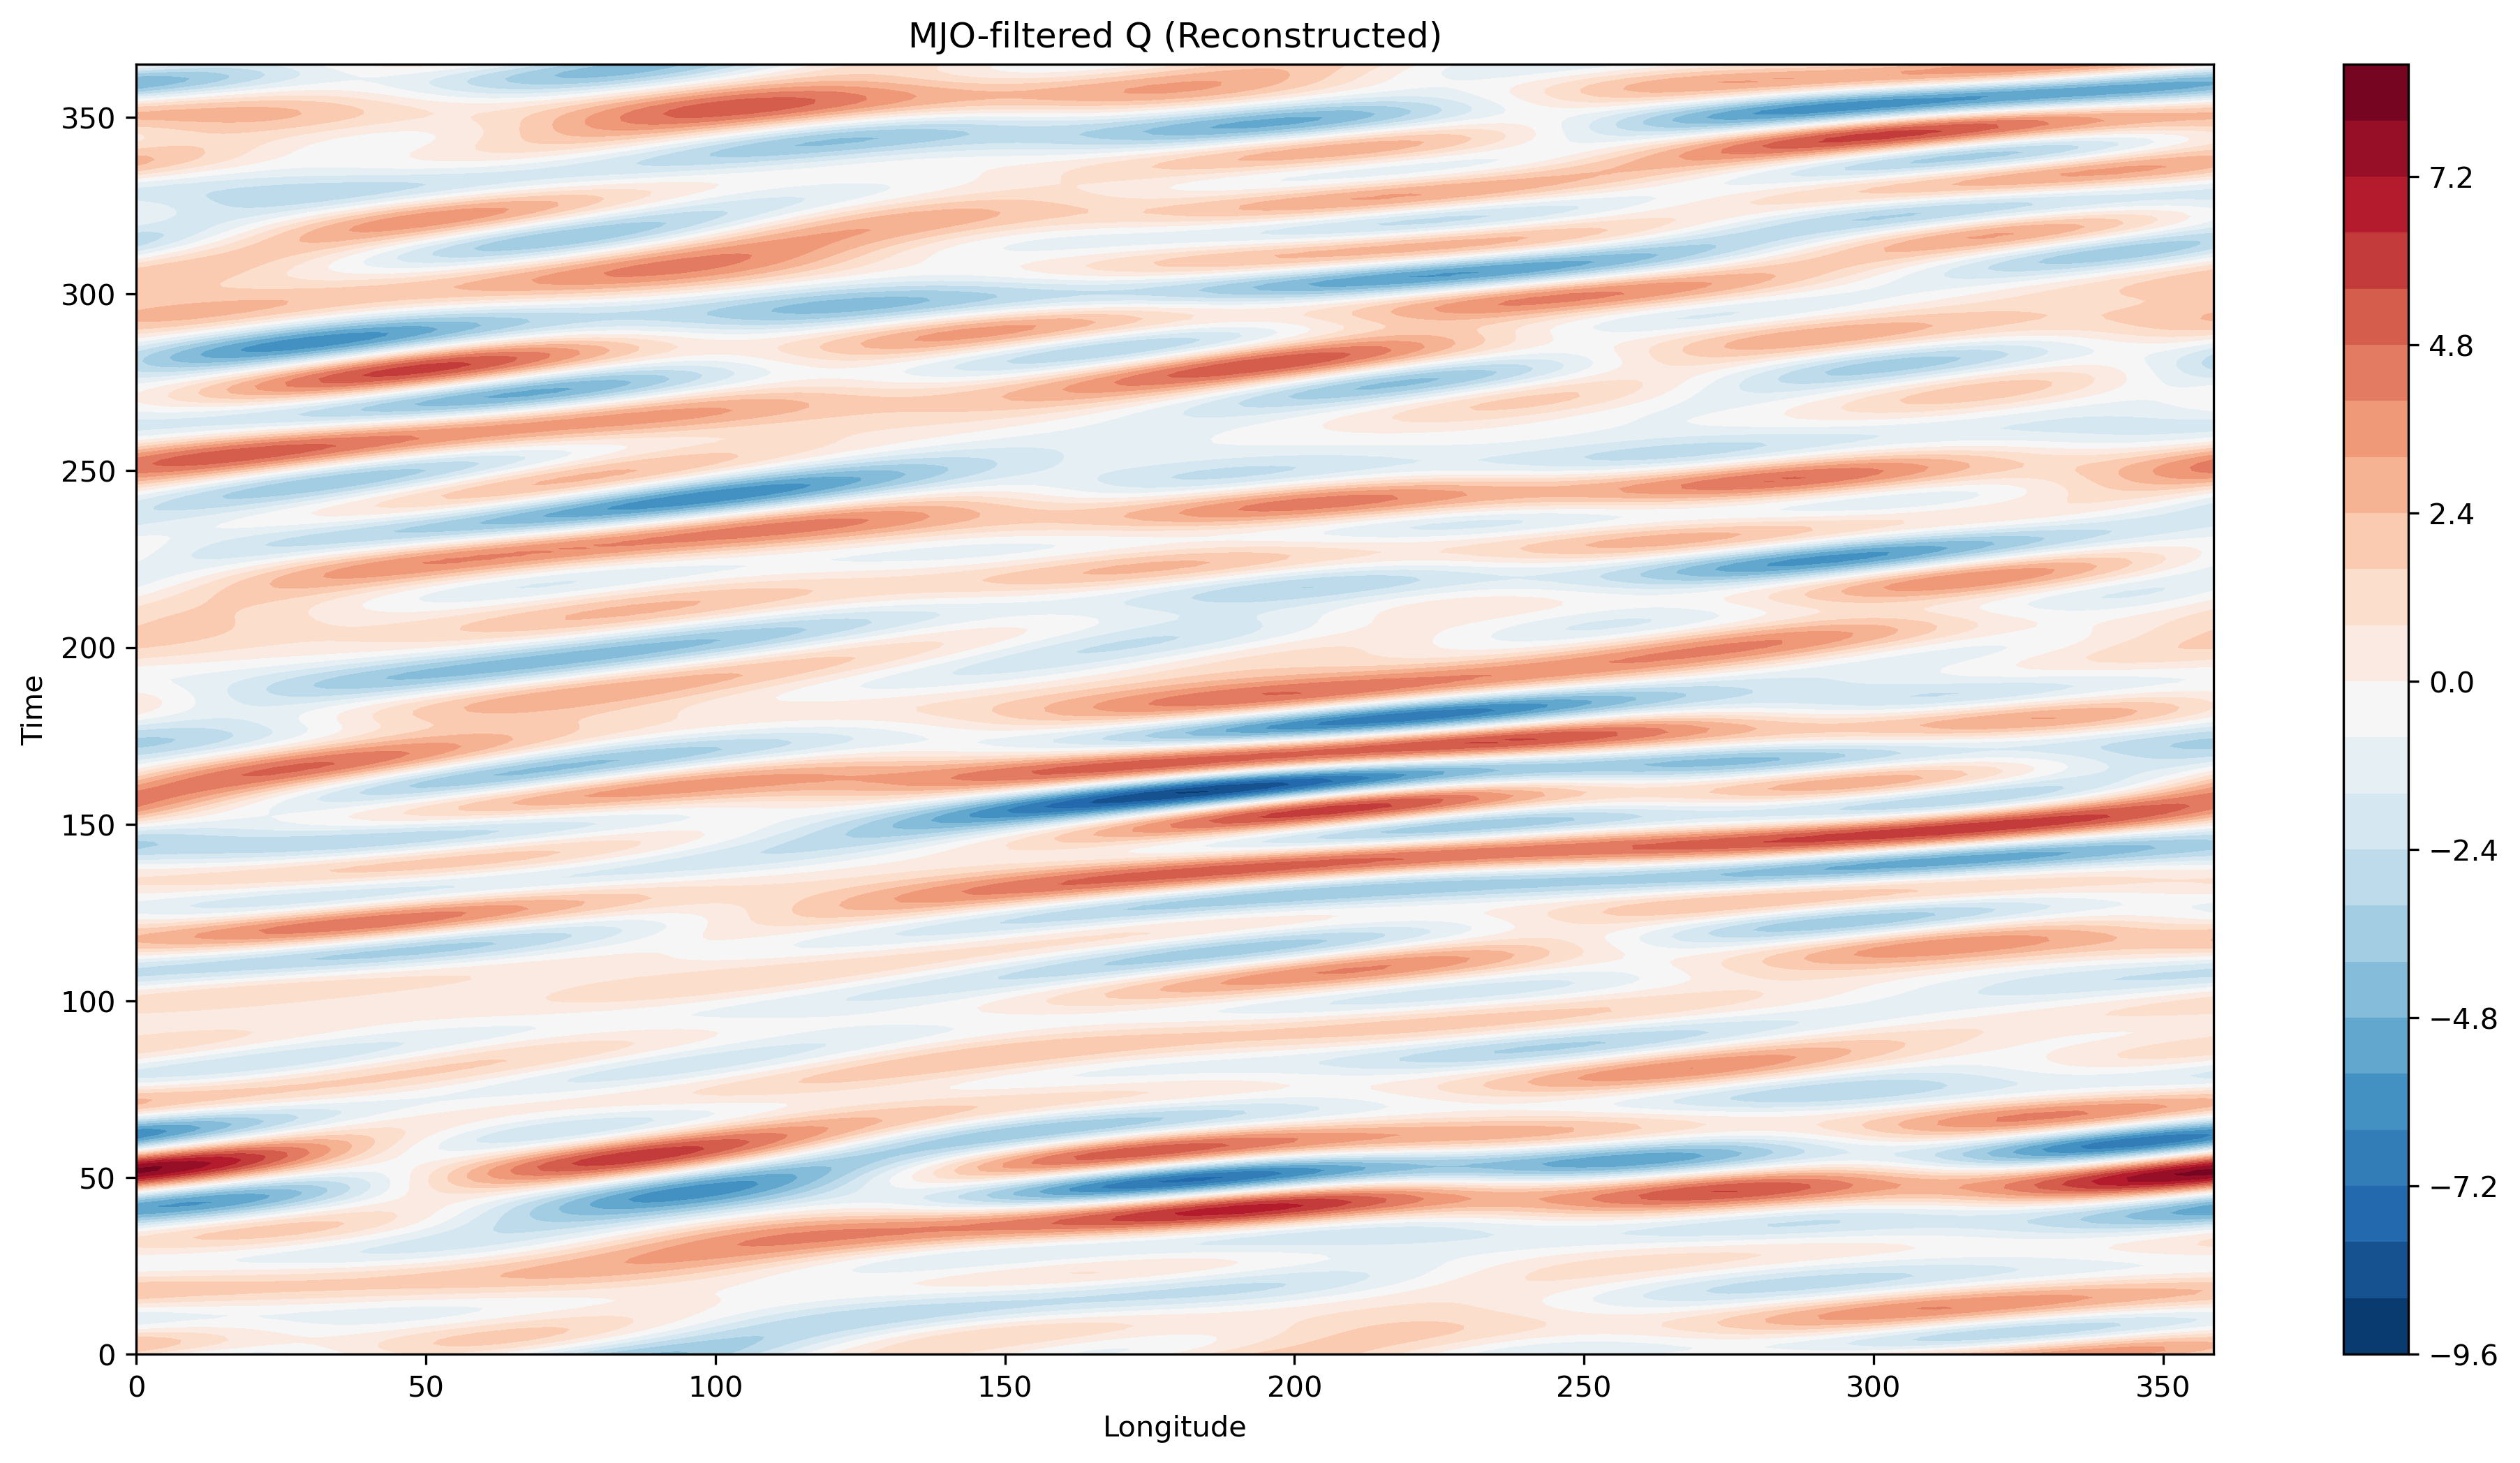

In [1218]:
# # 初始化
# mjo_filter = MJOFilter(wavenumber_range=(1, 5), period_range=(14, 60))

# # 濾波並取得 q_recon
# q_mjo = mjo_filter.fit_transform(Q, lat, lon, lat_range=(-15, 15))

# # 自己畫 Hovmöller（你用自己的方式）
# plt.figure(figsize=(16,8), dpi=300.)
# plt.contourf(lon, np.arange(q_mjo.shape[0]), q_mjo, levels=21, cmap="RdBu_r")
# plt.title("MJO-filtered Q (Reconstructed)")
# plt.xlabel("Longitude")
# plt.ylabel("Time")
# # plt.ylim([0,40])
# plt.colorbar()


In [1219]:
# def lag_composite_signal(q_mjo, PC, lags=np.arange(-20, 21), threshold=1.0):
#     """
#     Construct lag-longitude composite based on PC amplitude threshold.

#     Parameters:
#     - q_mjo: (time, lon) MJO-filtered field
#     - PC: (time,) reference index (e.g., PC1 from EOF)
#     - lags: array of lags to include (e.g., -20 to 20)
#     - threshold: only include times where |PC| > threshold

#     Returns:
#     - comp: (len(lags), lon), lag-lon composite
#     """
#     nt, nlon = q_mjo.shape
#     comp_stack = []

#     for t_ref in range(nt):
#         if np.abs(PC[t_ref]) < threshold:
#             continue
#         t_lag = t_ref + lags
#         if np.any((t_lag < 0) | (t_lag >= nt)):
#             continue
#         segment = q_mjo[t_lag, :]  # shape (lag, lon)
#         comp_stack.append(segment)

#     if len(comp_stack) == 0:
#         raise ValueError("No valid events found with given threshold.")

#     comp = np.mean(np.stack(comp_stack, axis=0), axis=0)
#     return comp


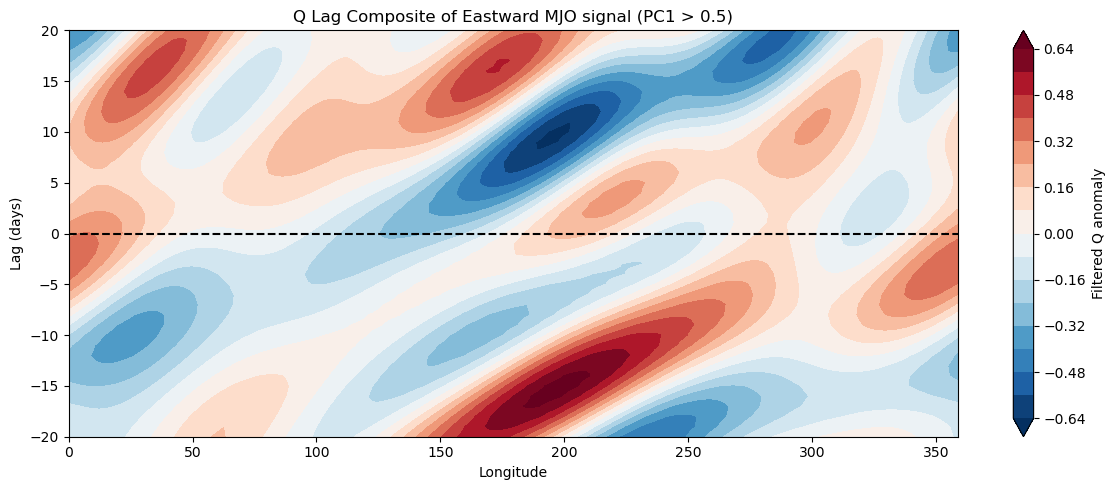

In [1221]:
# # composite
# comp = lag_composite_signal(q_mjo, PC1, lags=np.arange(-20, 21), threshold=0.5)

# # 畫圖
# plt.figure(figsize=(12, 5))
# cf = plt.contourf(lon, np.arange(-20, 21), comp, levels=21, cmap='RdBu_r', extend='both')
# plt.axhline(0, color='k', linestyle='--')
# plt.xlabel("Longitude")
# plt.ylabel("Lag (days)")
# plt.title("Q Lag Composite of Eastward MJO signal (PC1 > 0.5)")
# plt.colorbar(cf, label="Filtered Q anomaly")
# plt.tight_layout()
# plt.show()


# Regress on RMM Phase 1-8

In [1981]:
from scipy.signal import butter, filtfilt

def band_pass_filter(data, lowcut=1/90, highcut=1/50, fs=1):
    nyq = 0.5 * fs
    b, a = butter(2, [lowcut / nyq, highcut / nyq], btype='band')
    return filtfilt(b, a, data, axis=0)

import numpy as np

import numpy as np

def remove_seasonal_cycle(Q, num_harmonics=3):
    """
    Remove seasonal cycle using low-order Fourier harmonics.
    Supports input shape (time, lon) or (time, lat, lon).
    """
    ntime = Q.shape[0]
    t = np.arange(ntime)

    # Create time basis
    Q_detrended = Q.copy()
    for h in range(1, num_harmonics + 1):
        freq = 2 * np.pi * h / ntime
        cos_term = np.cos(freq * t)
        sin_term = np.sin(freq * t)

        if Q.ndim == 2:  # (time, lon)
            cos_term = cos_term[:, None]
            sin_term = sin_term[:, None]
            a = (Q * cos_term).mean(axis=0)
            b = (Q * sin_term).mean(axis=0)
            Q_detrended -= a[None, :] * cos_term
            Q_detrended -= b[None, :] * sin_term

        elif Q.ndim == 3:  # (time, lat, lon)
            cos_term = cos_term[:, None, None]
            sin_term = sin_term[:, None, None]
            a = (Q * cos_term).mean(axis=0)
            b = (Q * sin_term).mean(axis=0)
            Q_detrended -= a[None, :, :] * cos_term
            Q_detrended -= b[None, :, :] * sin_term

        else:
            raise ValueError("Input Q must be 2D or 3D (time, lon) or (time, lat, lon)")

    return Q_detrended




def preprocess_Q(Q, lat, lat_band=(-15, 15)):
    """
    Global anomaly → Remove seasonal cycle → Lat restrict + cos-weighted mean → Bandpass filter.
    Input:
        Q: (time, lat, lon)
        lat: (lat,)
    Returns:
        Q_filtered: (time, lon)
    """
    # Step 1: global anomaly (remove time mean at each grid point)
    Q_anom = Q - Q.mean(axis=0)

    # Step 2: remove seasonal cycle (grid-point wise)
    Q_deseasonal = remove_seasonal_cycle(Q_anom, num_harmonics=3)  # shape: (time, lat, lon)

    # Step 3: restrict latitude and do weighted average
    lat_mask = (lat >= lat_band[0]) & (lat <= lat_band[1])
    lat_sel = lat[lat_mask]
    weights = np.cos(np.deg2rad(lat_sel))
    weights /= weights.sum()

    Q_sel = Q_deseasonal[:, lat_mask, :]  # shape: (time, lat_subset, lon)
    Q_eq = np.average(Q_sel, axis=1, weights=weights)  # shape: (time, lon)

    # Step 4: band-pass filter
    Q_filtered = band_pass_filter(Q_eq)

    return Q_filtered







In [2190]:
with Dataset("f09.F2000_MJO_1year.cam.h0.1year.nc", "r") as f:
    
    Q = f["FLNT"][:]      # shape (time, lat, lon) 
    # Q = f["PRECL"][:] * 86400 * 1000      # shape (time, lat, lon) 
    u850 = f["U850"][:]
print(u850.shape)

(366, 192, 288)


In [2191]:
Q_filtered    = preprocess_Q(Q, lat, lat_band=(-15, 15))
u850_filtered = preprocess_Q(u850, lat, lat_band=(-15, 15))



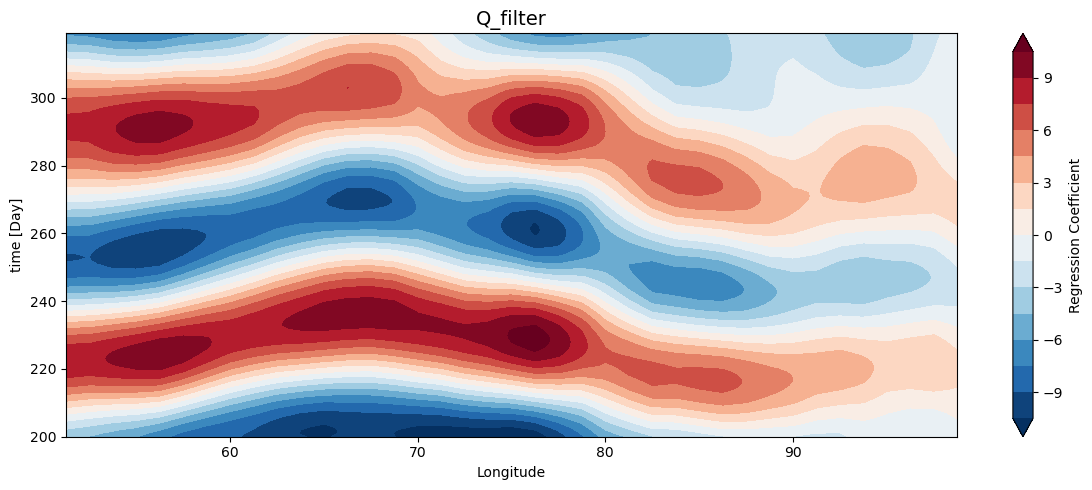

In [2101]:
# plt.figure()
plt.figure(figsize=(12, 5))
cf = plt.contourf(
    lon[lon_band],
    np.arange(200, 320),
    Q_filtered[200:320, :][:, lon_band],  
    levels=21,
    cmap="RdBu_r",
    extend="both"
)
plt.colorbar(cf, label="Regression Coefficient")
plt.xlabel("Longitude")
plt.ylabel("time [Day]")
plt.title("Q_filter", fontsize=14)
plt.tight_layout()
# plt.xlim([40,100])
# plt.ylim([30,70])
plt.show()

In [2192]:
def lagged_regression_against_reference(Q, ref_series, lags=np.arange(-20, 21)):
    """
    Regress Q(t, lon) ~ ref_series(t + lag)

    Parameters:
        Q: (time, lon) full field
        ref_series: (time,) reference time series
        lags: list of lags

    Returns:
        reg_map: (len(lags), lon)
    """
    nt, nlon = Q.shape
    reg_map = np.full((len(lags), nlon), np.nan)

    for i, lag in enumerate(lags):
        t = np.arange(nt)
        t_lag = t + lag
        valid = (t_lag >= 0) & (t_lag < nt)

        x = ref_series[t_lag[valid]]
        y = Q[t[valid]]

        cov = np.mean(x[:, None] * y, axis=0)
        var = np.mean(x ** 2)
        reg_map[i] = cov / var if var > 0 else 0

    return reg_map


In [2206]:
Q_filtered.shape

(366, 288)

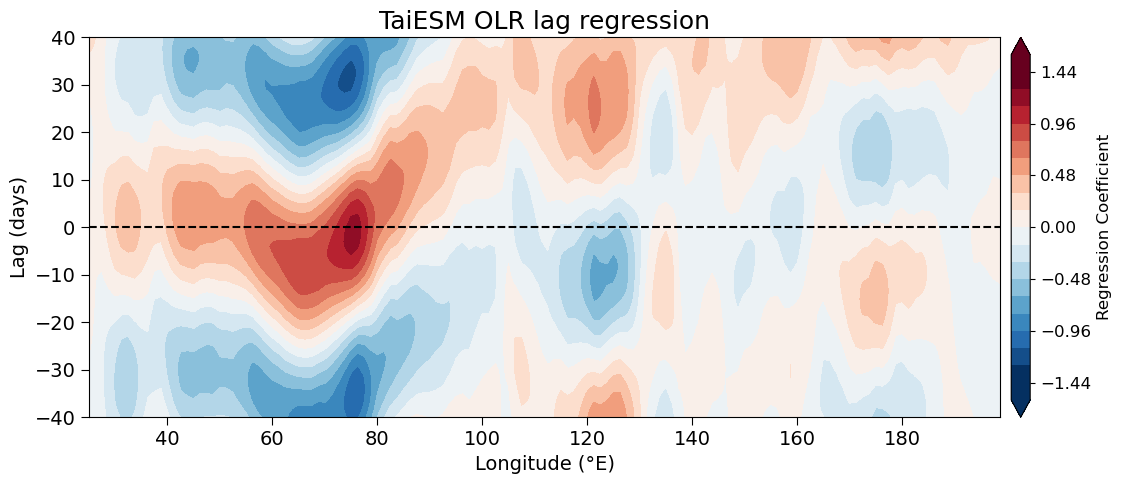

In [2208]:
# Step 1: 平均 Q_filtered 在 75–85°E 區間
ref_mask = (lon >= 75) & (lon <= 80)
ref_series = Q_filtered[:, ref_mask].mean(axis=1)  # shape: (time,)

# Step 2: 做回歸
reg_map = lagged_regression_against_reference(Q_filtered, ref_series, lags=np.arange(-40, 41))

# Step 3: 畫圖
from matplotlib.colors import TwoSlopeNorm
import matplotlib.pyplot as plt
import numpy as np

# Set global font (only for main plot, not colorbar)
plt.rcParams.update({
    "font.size": 12,
    "font.family": "sans-serif",
})

fig, ax = plt.subplots(1, figsize=(12, 5))

vabs = np.nanmax(np.abs(reg_map))
norm = TwoSlopeNorm(vmin=-vabs-0.15, vcenter=0, vmax=vabs+0.15)

cf = ax.contourf(
    lon[20:160], np.arange(-40, 41), reg_map[:, 20:160],
    levels=np.linspace(-vabs-0.4, vabs+0.4, 21),
    cmap="RdBu_r", norm=norm, extend="both"
)

ax.axhline(0, color='k', linestyle='--')
ax.set_xlabel("Longitude (°E)", fontsize=14)
ax.set_ylabel("Lag (days)", fontsize=14)
ax.set_title("TaiESM OLR lag regression", fontsize=18)
ax.tick_params(axis='both', labelsize=14, direction='out', length=6)

# Colorbar with default font
cbar = fig.colorbar(cf, ax=ax, label="Regression Coefficient", pad=0.01)
# → Do not modify colorbar font size

plt.tight_layout()
plt.show()




# Trash

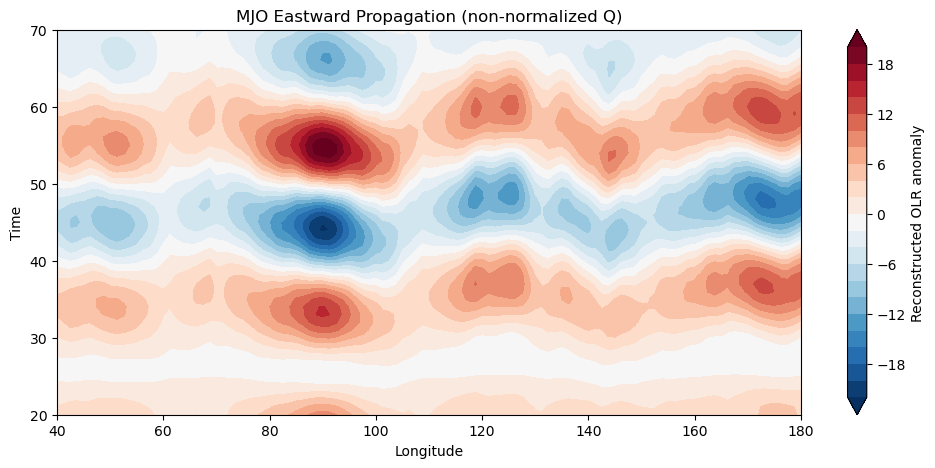

In [1395]:
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
from scipy.signal import butter, filtfilt
from sklearn.linear_model import LinearRegression

def band_pass_filter(data, lowcut=1/60, highcut=1/14, fs=1):
    nyq = 0.5 * fs
    b, a = butter(2, [lowcut / nyq, highcut / nyq], btype='band')
    return filtfilt(b, a, data, axis=0)

def preprocess_Q_nonnormalized(Q, lat, lat_band=(-15, 15)):
    """
    Lat-mean → Bandpass filter (NO normalization).
    Input:
        Q: (time, lat, lon)
        lat: (lat,)
    Returns:
        Q_filtered: (time, lon)
    """
    lat_mask = (lat >= lat_band[0]) & (lat <= lat_band[1])
    Q_sel = Q[:, lat_mask, :]  # (time, lat, lon)
    lat_sel = lat[lat_mask]

    # Latitude-weighted mean
    weights = np.cos(np.deg2rad(lat_sel))
    weights /= weights.sum()
    Q_eq = np.average(Q_sel, axis=1, weights=weights)  # shape: (time, lon)

    # Bandpass filter in time
    Q_filtered = band_pass_filter(Q_eq)

    return Q_filtered


# === Step 1: Load data ===
with Dataset("f09.F2000_MJO_1year.cam.h0.1year.nc", "r") as f:
    Q = f["FLNT"][:]  # shape: (time, lat, lon)
    lat = f["lat"][:]
    lon = f["lon"][:]

# Step 1: Q 不 normalize，只做 lat-mean + bandpass
Q_bandpassed = preprocess_Q_nonnormalized(Q, lat)

# Step 2: 回歸 Q to [PC1, -PC2]
X = np.stack([PC1, -PC2], axis=1)
model = LinearRegression().fit(X, Q_bandpassed)
coeffs = model.coef_
Q_recon = X @ coeffs.T  # shape: (time, lon)

# Step 3: Plot
plt.figure(figsize=(12, 5))
plt.contourf(lon, np.arange(Q_recon.shape[0]), Q_recon, levels=21, cmap='RdBu_r', extend='both')
plt.colorbar(label='Reconstructed OLR anomaly')
plt.title("MJO Eastward Propagation (non-normalized Q)")
plt.xlabel("Longitude")
plt.ylabel("Time")
plt.ylim([20,70])
plt.xlim([40,180])

plt.show()



In [1347]:
X.shape

(366, 2)

In [1348]:
coeffs.shape

(288, 2)

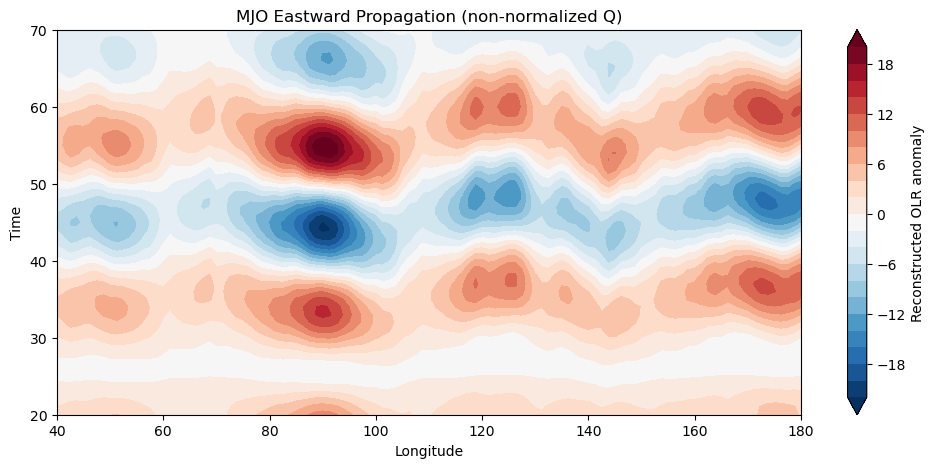

In [1400]:
# Step: filter only MJO-active time
rmm_amp = np.sqrt(PC1**2 + PC2**2)
mjo_mask = rmm_amp > 0.5  # or 1.5 if you want stricter

# Subset only active times
X_active = np.stack([PC1[mjo_mask], -PC2[mjo_mask]], axis=1)
Q_active = Q_bandpassed[mjo_mask, :]  # shape: (time, lon)

# Refit regression
model = LinearRegression().fit(X_active, Q_active)
coeffs = model.coef_

# Reconstruct over full time using all RMMs
X_all = np.stack([PC1, -PC2], axis=1)
Q_recon = X_all @ coeffs.T
# Step 3: Plot
plt.figure(figsize=(12, 5))
plt.contourf(lon, np.arange(Q_recon.shape[0]), Q_recon, levels=21, cmap='RdBu_r', extend='both')
plt.colorbar(label='Reconstructed OLR anomaly')
plt.title("MJO Eastward Propagation (non-normalized Q)")
plt.xlabel("Longitude")
plt.ylabel("Time")
plt.ylim([20,70])
plt.xlim([40,180])

plt.show()

In [1490]:
def band_pass_filter(data, lowcut=1/90, highcut=1/14, fs=1):
    nyq = 0.5 * fs
    b, a = butter(2, [lowcut / nyq, highcut / nyq], btype='band')
    return filtfilt(b, a, data, axis=0)

def composite_hovmoller_filtered(Q, PC1, PC2, lat, lon, target_phase=3, window=20, amp_thresh=0.5):
    """
    Composite Hovmöller (time x lon) centered on given RMM phase with bandpass-filtered Q.

    Q: (time, lat, lon)
    PC1, PC2: RMM components
    lat: latitude array
    lon: longitude array
    """
    # Step 1: Calculate phase & amplitude
    angle = np.arctan2(-PC2, PC1)
    angle_deg = (np.degrees(angle) + 360) % 360
    phase = np.floor(angle_deg / 45) + 1
    amp = np.sqrt(PC1**2 + PC2**2)
    
    centers = np.where((phase == target_phase) & (amp > amp_thresh))[0]
    centers = centers[(centers >= window) & (centers < len(PC1) - window)]

    print(f"Valid events for phase {target_phase}: {len(centers)}")

    # Step 2: Latitudinal average (cosine weight)
    lat_mask = (lat >= -15) & (lat <= 15)
    Q_sel = Q[:, lat_mask, :]
    lat_sel = lat[lat_mask]
    weights = np.cos(np.deg2rad(lat_sel))
    weights /= weights.sum()
    Q_eq = np.average(Q_sel, axis=1, weights=weights)  # shape: (time, lon)

    # Step 3: Bandpass Q
    Q_eq_bp = band_pass_filter(Q_eq)
    # Q_eq_bp -= Q_eq_bp.mean(axis=0, keepdims=True)

    # Step 4: Extract windows and composite
    stack = []
    for idx in centers:
        segment = Q_eq_bp[idx - window : idx + window + 1, :]
        stack.append(segment)
    stack = np.array(stack)

    composite = np.mean(stack, axis=0)
    return composite

def lagged_regression(Q_eq, PC1, max_lag=20):
    """
    Regression of Q_eq (time, lon) onto lagged PC1 (time,).
    Returns: lag × lon array
    """
    from scipy.stats import linregress
    lags = np.arange(-max_lag, max_lag + 1)
    result = np.zeros((len(lags), Q_eq.shape[1]))

    for i, lag in enumerate(lags):
        if lag < 0:
            y = Q_eq[:lag, :]
            x = PC1[-lag:]
        elif lag > 0:
            y = Q_eq[lag:, :]
            x = PC1[:-lag]
        else:
            y = Q_eq
            x = PC1
        for j in range(Q_eq.shape[1]):
            slope, _, _, _, _ = linregress(x, y[:, j])
            result[i, j] = slope
    return lags, result


Valid events for phase(s) [3, 4]: 70


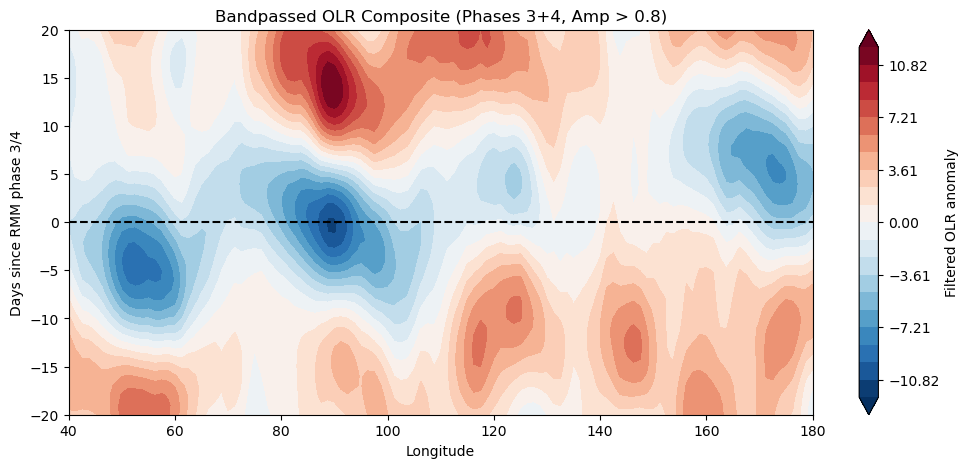

In [1492]:
# 修正 bandpass
def band_pass_filter(data, lowcut=1/96, highcut=1/20, fs=1):
    nyq = 0.5 * fs
    b, a = butter(2, [lowcut / nyq, highcut / nyq], btype='band')
    return filtfilt(b, a, data, axis=0)

# 加入 subtract time mean + flexible phase set
def composite_hovmoller_filtered(Q, PC1, PC2, lat, lon, phases=[3], window=20, amp_thresh=0.8):
    angle = np.arctan2(-PC2, PC1)
    phase = (np.degrees(angle) + 360) % 360
    phase = np.floor(phase / 45) + 1
    amp = np.sqrt(PC1**2 + PC2**2)

    idx = np.where(np.isin(phase, phases) & (amp > amp_thresh))[0]
    idx = idx[(idx >= window) & (idx < len(PC1) - window)]
    print(f"Valid events for phase(s) {phases}: {len(idx)}")

    lat_mask = (lat >= -15) & (lat <= 15)
    weights = np.cos(np.deg2rad(lat[lat_mask]))
    weights /= weights.sum()
    Q_eq = np.average(Q[:, lat_mask, :], axis=1, weights=weights)

    Q_eq_bp = band_pass_filter(Q_eq)
    Q_eq_bp -= Q_eq_bp.mean(axis=0, keepdims=True)  # remove time mean

    stack = [Q_eq_bp[i-window:i+window+1, :] for i in idx]
    composite = np.mean(np.array(stack), axis=0)
    return composite

# Run
composite = composite_hovmoller_filtered(Q, PC1, PC2, lat, lon, phases=[3,4], window=20, amp_thresh=0.8)

# Plot
vmax = np.max(np.abs(composite))
rel_time = np.arange(-20, 21)

plt.figure(figsize=(12, 5))
plt.contourf(lon, rel_time, composite, levels=np.linspace(-vmax, vmax, 21), cmap="RdBu_r", extend="both")
plt.axhline(0, color='k', linestyle='--')
plt.colorbar(label="Filtered OLR anomaly")
plt.xlabel("Longitude")
plt.ylabel("Days since RMM phase 3/4")
plt.title("Bandpassed OLR Composite (Phases 3+4, Amp > 0.8)")
plt.xlim([40,180])
plt.show()


In [1516]:
from scipy.stats import linregress

def band_pass_filter(data, lowcut=1/96, highcut=1/20, fs=1):
    nyq = 0.5 * fs
    b, a = butter(2, [lowcut / nyq, highcut / nyq], btype='band')
    return filtfilt(b, a, data, axis=0)

def lagged_regression_field(field, pc, max_lag=20):
    """
    Lagged regression: how field responds to pc(t) at lag.
    field(t, lon), pc(t)
    """
    ntime, nlon = field.shape
    lags = np.arange(-max_lag, max_lag + 1)
    result = np.zeros((len(lags), nlon))

    for i, lag in enumerate(lags):
        if lag < 0:
            x = pc[:lag]                  # PC1(t)
            y = field[-lag:, :]          # Q(t + lag)
        elif lag > 0:
            x = pc[lag:]                 # PC1(t)
            y = field[:-lag, :]          # Q(t + lag)
        else:
            x = pc
            y = field
        for j in range(nlon):
            slope, _, _, _, _ = linregress(x, y[:, j])
            result[i, j] = slope
    return lags, result


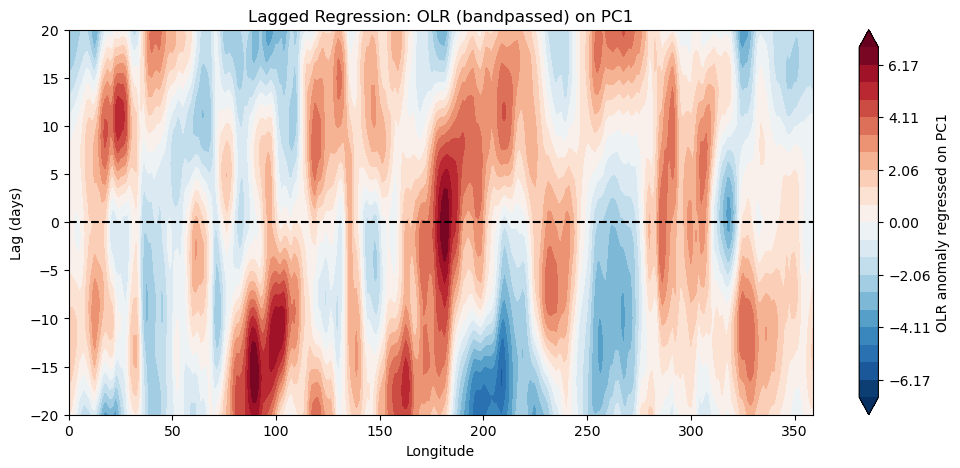

In [1519]:
# Step 1: 緯向平均 OLR
lat_mask = (lat >= -15) & (lat <= 15)
weights = np.cos(np.deg2rad(lat[lat_mask]))
weights /= weights.sum()
Q_eq = np.average(Q[:, lat_mask, :], axis=1, weights=weights)  # (time, lon)

# Step 2: bandpass 過濾
Q_eq_bp = band_pass_filter(Q_eq)

# Step 3: lagged regression onto RMM index
RMM_idx = np.sqrt(PC1**2 + PC2**2)
lags, reg_map = lagged_regression_field(Q_eq_bp, RMM_idx, max_lag=20)

# Step 4: 繪圖
plt.figure(figsize=(12, 5))
vmax = np.max(np.abs(reg_map))
plt.contourf(lon, lags, reg_map, levels=np.linspace(-vmax, vmax, 21), cmap="RdBu_r", extend="both")
# plt.contour(lon, lags, reg_map, levels=np.linspace(-vmax, vmax, 9), colors='k', linewidths=0.4)
plt.axhline(0, color='k', linestyle='--')
plt.colorbar(label='OLR anomaly regressed on PC1')
plt.xlabel("Longitude")
plt.ylabel("Lag (days)")
plt.title("Lagged Regression: OLR (bandpassed) on PC1")
# plt.xlim([40, 180])
plt.show()


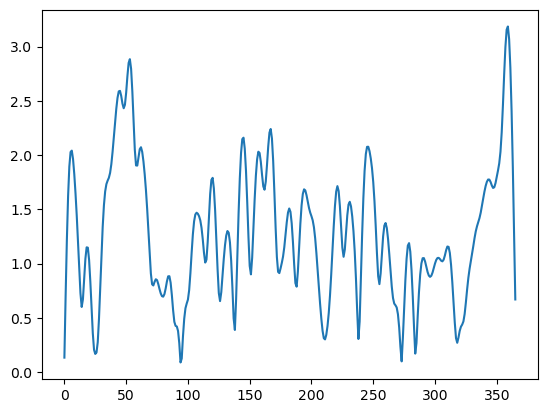

In [1520]:
plt.figure()
plt.plot(RMM_idx)


In [1558]:
from sklearn.linear_model import LinearRegression

def lagged_multivariate_regression(Q_eq, PC1, PC2, max_lag=20):
    """
    Regress Q_eq(t + lag) on [PC1(t), PC2(t)]
    Returns: (lags, lon), regression amplitude for both PCs
    """
    lags = np.arange(-max_lag, max_lag + 1)
    n_lag = len(lags)
    nlon = Q_eq.shape[1]
    
    A1 = np.zeros((n_lag, nlon))  # coefficients for PC1
    A2 = np.zeros((n_lag, nlon))  # coefficients for PC2
    
    for i, lag in enumerate(lags):
        if lag < 0:
            y = Q_eq[-lag:, :]
            x = np.stack([PC1[:lag], PC2[:lag]], axis=1)
        elif lag > 0:
            y = Q_eq[:-lag, :]
            x = np.stack([PC1[lag:], PC2[lag:]], axis=1)
        else:
            y = Q_eq
            x = np.stack([PC1, PC2], axis=1)
        
        for j in range(nlon):
            model = LinearRegression().fit(x, y[:, j])
            A1[i, j] = model.coef_[0]  # PC1
            A2[i, j] = model.coef_[1]  # PC2
    
    return lags, A1, A2
def reconstruct_phase_composite(A1, A2, phase_number):
    """
    Given regression coeffs A1 (PC1), A2 (PC2), reconstruct the OLR composite at a given MJO phase (1~8).
    """
    angle_deg = (phase_number - 1) * 45
    phi = np.deg2rad(angle_deg)
    return A1 * np.cos(phi) + A2 * np.sin(phi)


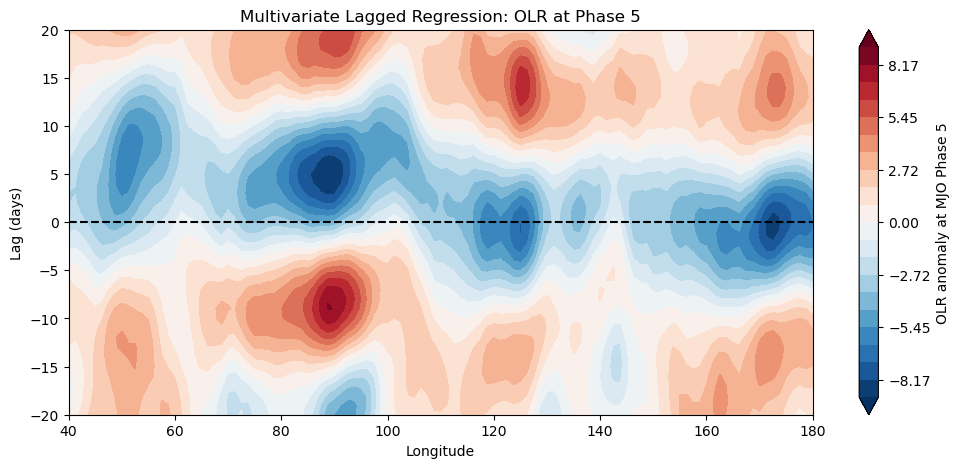

In [1565]:
with Dataset("f09.F2000_MJO_1year.cam.h0.1year.nc", "r") as f:
    Q = f["FLNT"][:]  # shape: (time, lat, lon)
    lat = f["lat"][:]
    lon = f["lon"][:]


# Step 1: 緯向平均
lat_mask = (lat >= -10) & (lat <= 10)
weights = np.cos(np.deg2rad(lat[lat_mask]))
weights /= weights.sum()
Q_eq = np.average(Q[:, lat_mask, :], axis=1, weights=weights)

# Step 2: bandpass
Q_eq_bp = band_pass_filter(Q_eq)

# Step 3: multivariate lagged regression
lags, A1, A2 = lagged_multivariate_regression(Q_eq_bp, PC1, PC2, max_lag=20)

# Step 4: 選一個 MJO phase 來重建
composite_p5 = reconstruct_phase_composite(A1, A2, phase_number=5)

# Step 5: 繪圖
plt.figure(figsize=(12, 5))
vmax = np.max(np.abs(composite_p5))
plt.contourf(lon, lags, composite_p5, levels=np.linspace(-vmax, vmax, 21), cmap="RdBu_r", extend="both")
plt.axhline(0, color='k', linestyle='--')
plt.colorbar(label="OLR anomaly at MJO Phase 5")
plt.xlabel("Longitude")
plt.ylabel("Lag (days)")
plt.title("Multivariate Lagged Regression: OLR at Phase 5")
plt.xlim([40, 180])
plt.show()



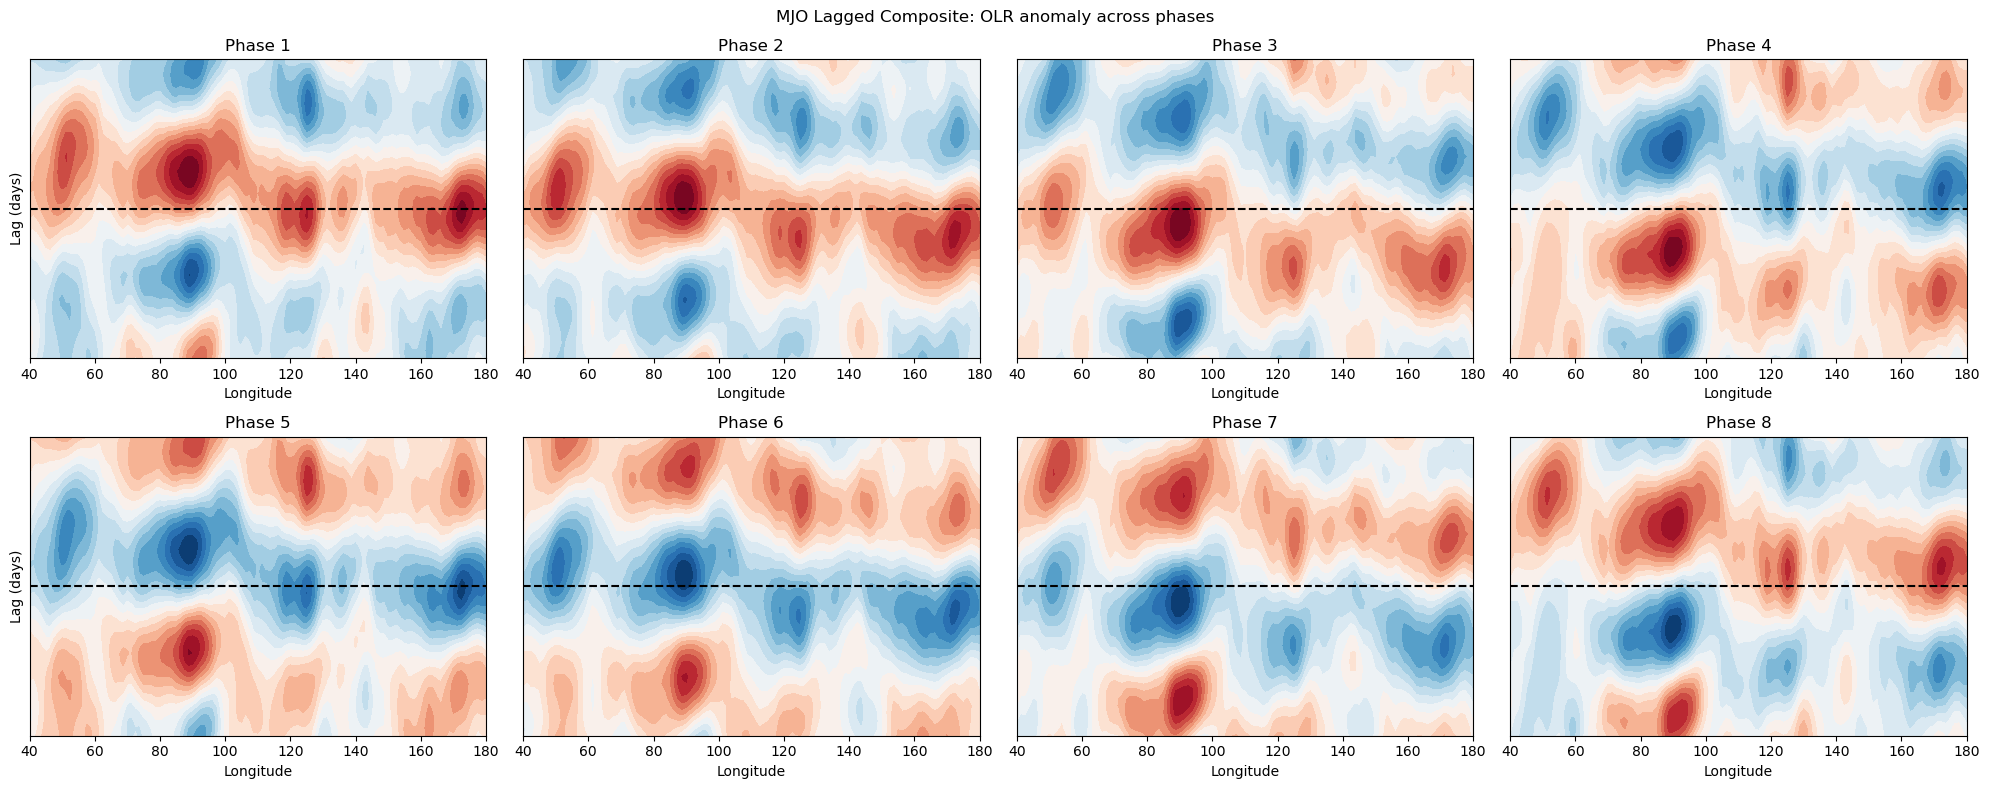

In [1562]:
fig, axs = plt.subplots(2, 4, figsize=(20, 8), sharey=True)

for i in range(8):
    phase_i = i + 1
    comp = reconstruct_phase_composite(A1, A2, phase_i)
    vmax = np.max(np.abs(comp))
    
    ax = axs.flat[i]
    ax.contourf(lon, lags, comp, levels=np.linspace(-vmax, vmax, 21), cmap="RdBu_r", extend="both")
    ax.set_title(f"Phase {phase_i}")
    ax.axhline(0, color='k', linestyle='--')
    ax.set_xlim([40, 180])
    if i % 4 == 0:
        ax.set_ylabel("Lag (days)")
    else:
        ax.set_yticks([])
    ax.set_xlabel("Longitude")

plt.suptitle("MJO Lagged Composite: OLR anomaly across phases")
plt.tight_layout()
plt.show()


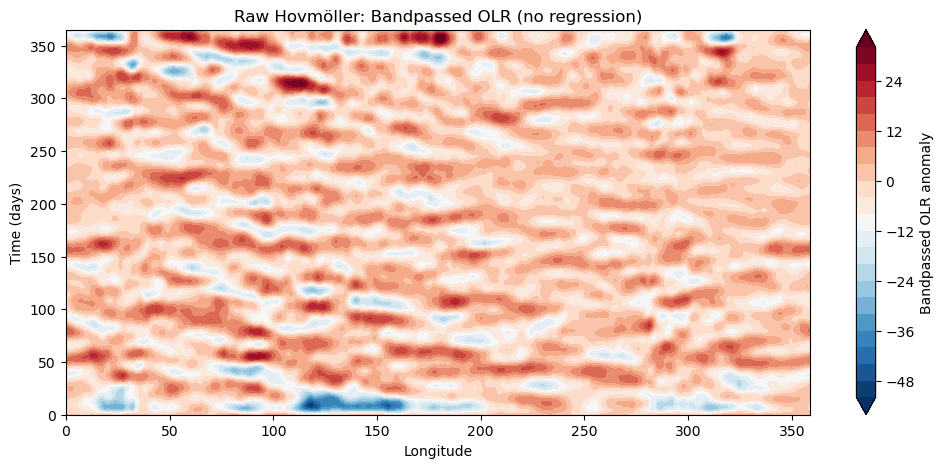

In [1532]:
plt.figure(figsize=(12, 5))
plt.contourf(lon, np.arange(Q_eq.shape[0]), Q_eq_bp, levels=21, cmap='RdBu_r', extend='both')
plt.colorbar(label="Bandpassed OLR anomaly")
plt.xlabel("Longitude")
plt.ylabel("Time (days)")
plt.title("Raw Hovmöller: Bandpassed OLR (no regression)")
plt.show()


In [1533]:
from sklearn.decomposition import PCA

# 先處理 Q_eq (你之前的緯向加權平均)
Q_eq_anom = Q_eq_bp - Q_eq_bp.mean(axis=0)  # remove time mean
pca = PCA(n_components=4)
pcs = pca.fit_transform(Q_eq_anom)   # (time, ncomp)
eofs = pca.components_               # (ncomp, lon)
explained = pca.explained_variance_ratio_


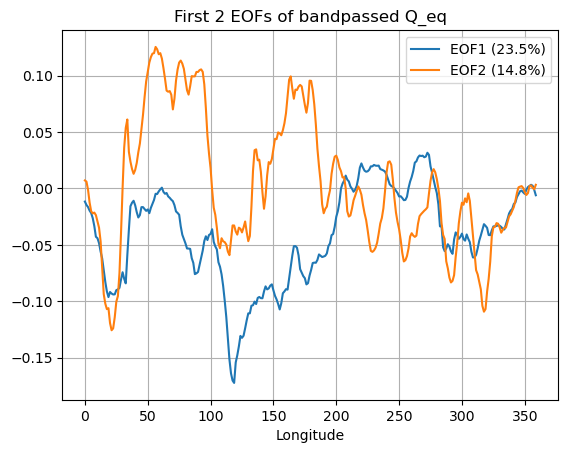

In [1534]:
for i in range(2):
    plt.plot(lon, eofs[i], label=f"EOF{i+1} ({explained[i]*100:.1f}%)")
plt.legend()
plt.title("First 2 EOFs of bandpassed Q_eq")
plt.xlabel("Longitude")
plt.grid()
plt.show()


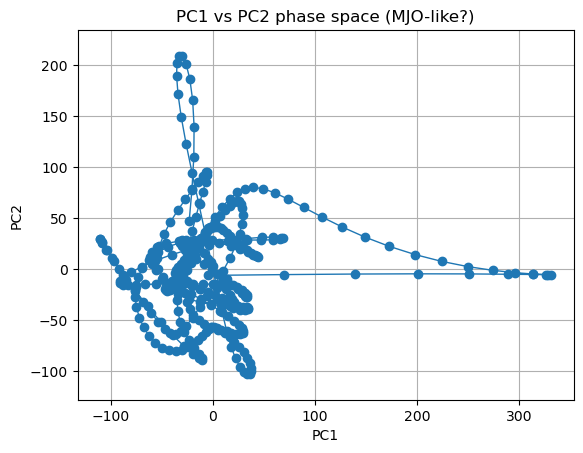

In [1535]:
plt.plot(pcs[:,0], pcs[:,1], marker='o', lw=1)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PC1 vs PC2 phase space (MJO-like?)")
plt.grid()
plt.axis('equal')
plt.show()


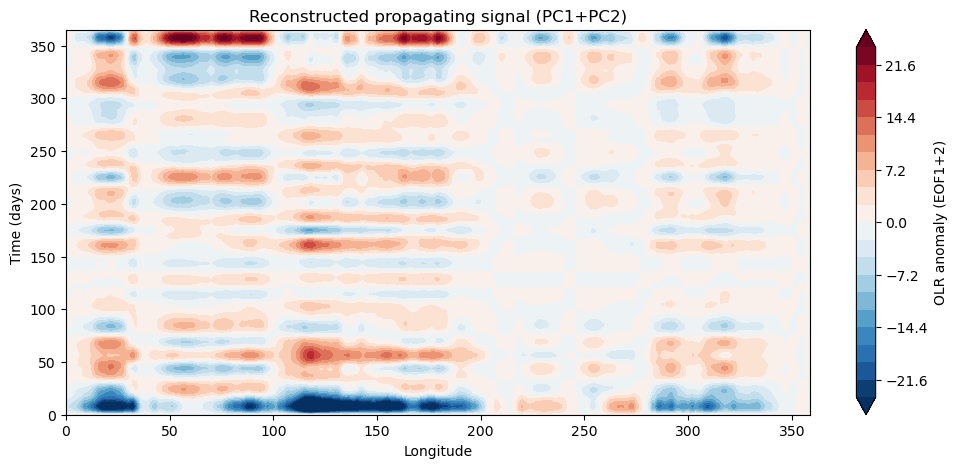

In [1538]:
Q_recon = pcs[:, 0:2] @ eofs[0:2, :]  # shape: (time, lon)

plt.figure(figsize=(12, 5))
plt.contourf(lon, np.arange(Q_recon.shape[0]), Q_recon, levels=np.linspace(-24,24,21), cmap='RdBu_r', extend='both')
plt.title("Reconstructed propagating signal (PC1+PC2)")
plt.xlabel("Longitude")
plt.ylabel("Time (days)")
plt.colorbar(label="OLR anomaly (EOF1+2)")
plt.show()


In [1551]:
# 假設你還有 Q, lat, lon（OLR 資料）
lat_mask = (lat >= -15) & (lat <= 15)
Q_sel = Q[:, lat_mask, :]  # shape: (time, lat, lon)
lat_sel = lat[lat_mask]

# Cosine weighting
weights = np.cos(np.deg2rad(lat_sel))
weights /= weights.sum()

# 緯向加權平均 → 得到 Q_eq: shape = (time, lon)
Q_eq = np.average(Q_sel, axis=1, weights=weights)


In [1629]:
def normalize_along_time(data):
    mean = data.mean(axis=0)
    std = data.std(axis=0)
    std[std == 0] = 1  # avoid divide-by-zero
    return (data - mean) / std


In [1630]:
def regress_1d(x, y):
    """
    Regress y onto x (both shape: time,)
    Return slope only (not intercept)
    """
    return np.sum(x * y) / np.sum(x * x)


In [1631]:
def regression_onto_x(x, y):
    """
    Regress y (time, lon) onto x (time, lon) → returns slope (lon,)
    Both x and y should be normalized.
    """
    return np.array([regress_1d(x[:, i], y[:, i]) for i in range(x.shape[1])])


In [ ]:
def preprocess_Q_nonnormalized(Q, lat, lat_band=(-15, 15)):
    """
    Lat-mean → Bandpass filter (NO normalization).
    Input:
        Q: (time, lat, lon)
        lat: (lat,)
    Returns:
        Q_filtered: (time, lon)
    """
    lat_mask = (lat >= lat_band[0]) & (lat <= lat_band[1])
    Q_sel = Q[:, lat_mask, :]  # (time, lat, lon)
    lat_sel = lat[lat_mask]

    # Latitude-weighted mean
    weights = np.cos(np.deg2rad(lat_sel))
    weights /= weights.sum()
    Q_eq = np.average(Q_sel, axis=1, weights=weights)  # shape: (time, lon)

    # Bandpass filter in time
    Q_filtered = band_pass_filter(Q_eq)

    return Q_filtered

In [1639]:
import numpy as np

def normalize_along_time(data):
    """
    Normalize along time axis: (time, ...) → z-score
    """
    mean = data.mean(axis=0)
    std = data.std(axis=0)
    std[std == 0] = 1  # avoid divide by zero
    return (data - mean) / std

def regression_slope_only(x, y):
    """
    Compute regression slope β(x) for each lon.
    x, y: shape (time, lon)
    Returns: β(lon,)
    """
    return np.sum(x * y, axis=0) / np.sum(x * x, axis=0)

def project_regression(x, beta):
    """
    Project x (time, lon) with β (lon,) to get predicted y (time, lon)
    """
    return x * beta[None, :]


In [1640]:
# Step 1: normalize both predictors and targets
OLR_norm = normalize_along_time(Q_filtered)   # shape: (time, lon)
u850_eq = u850[:, lat_mask, :]                # restrict to same lat_band
u850_eq = np.average(u850_eq, axis=1, weights=weights)  # shape: (time, lon)
u850_norm = normalize_along_time(u850_eq)

# Step 2: regression: u850 ~ OLR
beta = regression_slope_only(OLR_norm, u850_norm)  # shape: (lon,)

# Step 3: reconstruct u850 based on OLR
u850_regressed = project_regression(OLR_norm, beta)  # shape: (time, lon)


In [1642]:
u850_regressed.shape

(366, 288)

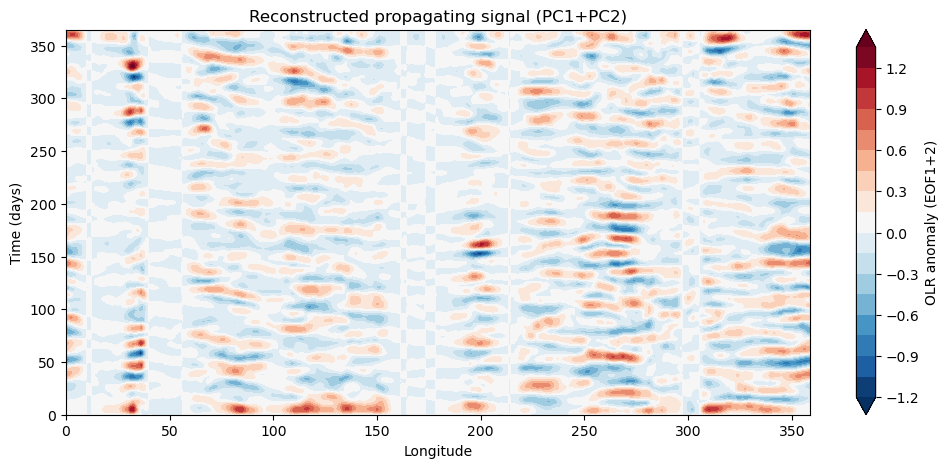

In [1644]:
plt.figure(figsize=(12, 5))
plt.contourf(lon, np.arange(Q_recon.shape[0]), u850_regressed, levels=21, cmap='RdBu_r', extend='both')
plt.title("Reconstructed propagating signal (PC1+PC2)")
plt.xlabel("Longitude")
plt.ylabel("Time (days)")
plt.colorbar(label="OLR anomaly (EOF1+2)")
plt.show()

In [1636]:
with Dataset("f09.F2000_MJO_1year.cam.h0.1year.nc", "r") as f:
    Q = f["FLNT"][:]  # shape: (time, lat, lon)
    u850 = f["U850"][:]
    lat = f["lat"][:]
    lon = f["lon"][:]

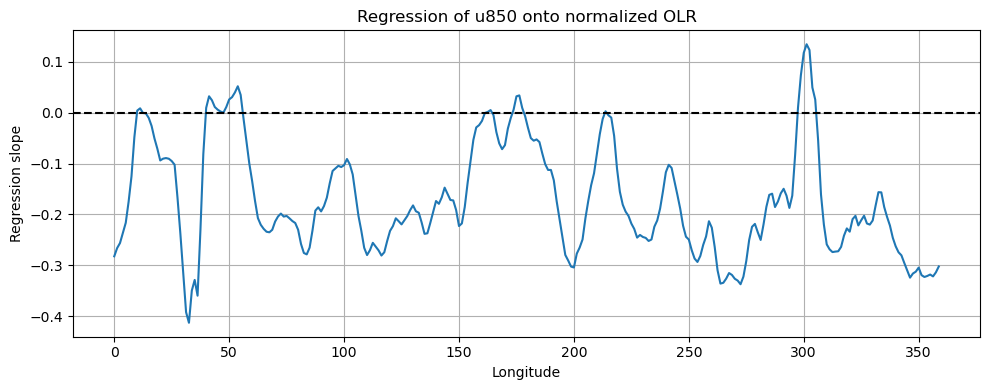

In [1657]:
u850_filtered = preprocess_Q_nonnormalized(u850, lat, lat_band=(-15, 15))
# Normalize OLR and u850 along time
OLR_norm = normalize_along_time(Q_filtered)      # (time, lon)
u850_norm = normalize_along_time(u850_eq)        # (time, lon)

# Regression: u850 = b * OLR
slope_u850_on_OLR = regression_onto_x(OLR_norm, u850_norm)  # (lon,)

# Optional: plot result
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
plt.plot(lon, slope_u850_on_OLR)
plt.axhline(0, color='k', linestyle='--')
plt.title("Regression of u850 onto normalized OLR")
plt.xlabel("Longitude")
plt.ylabel("Regression slope")
plt.grid(True)
plt.tight_layout()
plt.show()


In [1658]:
import numpy as np

def normalize_along_time(data):
    """
    Normalize along time axis: (time, ...) → z-score
    """
    mean = data.mean(axis=0)
    std = data.std(axis=0)
    std[std == 0] = 1  # avoid divide by zero
    return (data - mean) / std

def regression_slope_only(x, y):
    """
    Compute regression slope β(x) for each lon.
    x, y: shape (time, lon)
    Returns: β(lon,)
    """
    return np.sum(x * y, axis=0) / np.sum(x * x, axis=0)

def project_regression(x, beta):
    """
    Project x (time, lon) with β (lon,) to get predicted y (time, lon)
    """
    return x * beta[None, :]


In [1737]:
with Dataset("f09.F2000_MJO_1year.cam.h0.1year.nc", "r") as f:
    Q = f["FLNT"][:]  # shape: (time, lat, lon)
    u850 = f["U850"][:]
    u200 = f["U200"][:]
    
    lat = f["lat"][:]
    lon = f["lon"][:]

In [1713]:
u200_filtered = preprocess_Q_nonnormalized(u200, lat, lat_band=(-15, 15))
u850_filtered = preprocess_Q_nonnormalized(u850, lat, lat_band=(-15, 15))


OLR_norm = normalize_along_time(Q_filtered)        # (time, lon)
u850_norm = normalize_along_time(u850_filtered)    # (time, lon)
u200_norm = normalize_along_time(u200_filtered)    # (time, lon)


In [1732]:
beta_u850 = regression_slope_only(u850_norm, OLR_norm)
beta_u200 = regression_slope_only(u200_norm, OLR_norm)

u850_regressed = project_regression(OLR_norm, beta_u850)
u200_regressed = project_regression(OLR_norm, beta_u200)


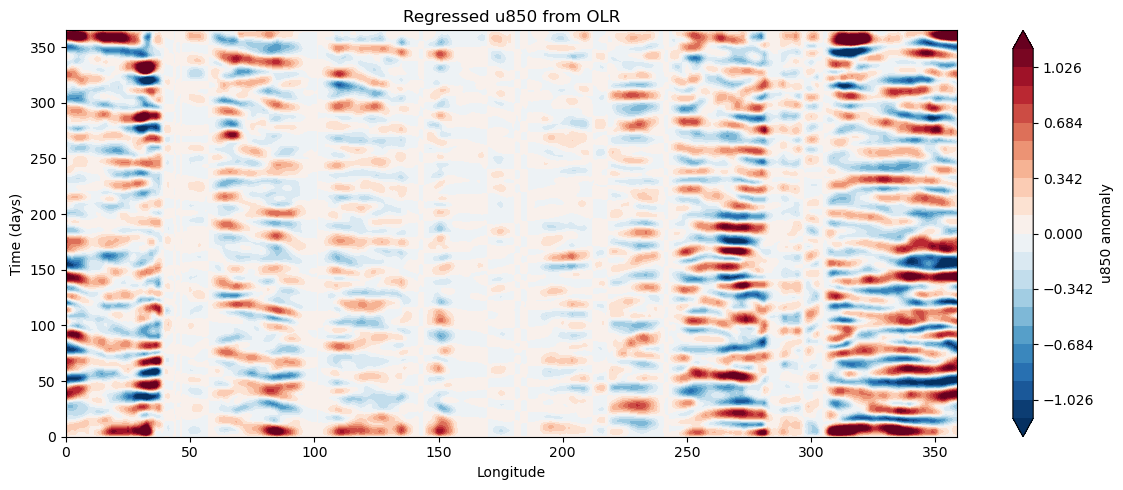

In [1736]:
# Example: Plot regressed u850
# max = u850_regressed[np.ix_(time_band, lon_band)].max()
plt.figure(figsize=(12, 5))
plt.contourf(
    lon,
    time,
    u850_regressed,
    levels=np.linspace(-max, max, 21),
    cmap='RdBu_r',
    extend='both'
)
plt.xlabel("Longitude")
plt.ylabel("Time (days)")
plt.title("Regressed u850 from OLR")
plt.colorbar(label="u850 anomaly")
plt.tight_layout()
# plt.ylim([260,300])
plt.show()


# # Plot regressed u200
# plt.figure(figsize=(12, 5))
# max = u200_regressed[np.ix_(time_band, lon_band)].max()
# plt.contourf(
#     lon[lon_band],
#     time[time_band],
#     u200_regressed[np.ix_(time_band, lon_band)],
#     levels=np.linspace(-max, max, 21),
#     cmap='RdBu_r',
#     extend='both'
# 0
# plt.xlabel("Longitude")
# plt.ylabel("Time (days)")
# plt.title("Regressed u200 from OLR")
# plt.colorbar(label="u200 anomaly")
# plt.tight_layout()
# plt.show()


In [1721]:
u200_regressed[np.ix_(time_band, lon_band)].shape

(129, 39)